# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.
/media/rodsnjr/Files/miniconda3/envs/aind-dog/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


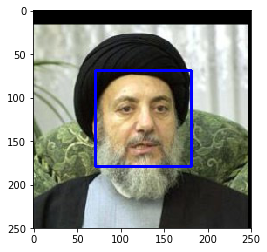

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
99 % of human faces, and 11% of dog faces

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_detected = 0
dogs_faces_detected = 0
for dog_face, human_face in zip(dog_files_short, human_files_short):
    faces_detected += 1 if face_detector(human_face) else 0
    dogs_faces_detected += 1 if face_detector(dog_face) else 0
    
print(faces_detected, dogs_faces_detected)

99 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ It's reasonable depending on the user's necessities. In a requirements like a security system that might not be the case. There are more complex approaches based on deep learning that might be useful to detect faces, such as [OpenFace](https://github.com/cmusatyalab/openface) and [Facenet](https://github.com/davidsandberg/facenet/).

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [24]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
3% of human images detected a dog, and 100% of the dogs images detected as dogs

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
faces_detected = 0
dogs_faces_detected = 0
for dog_face, human_face in zip(dog_files_short, human_files_short):
    faces_detected += 1 if dog_detector(human_face) else 0
    dogs_faces_detected += 1 if dog_detector(dog_face) else 0
    
print(faces_detected, dogs_faces_detected)

3 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 96.70it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ : I've used the example of the [Keras Cifar 10](https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py), it has a good accuracy of 75% in the Cifar 10, training for 50 epochs. Personally I believe it's easier to follow with a sample/already OK architecture, and tune it to your problem.

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential

num_classes = 133

# Ref architecture: https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_tensors.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 111, 111, 64)      18496     
__________

### Compile the Model

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [22]:
from keras.callbacks import ModelCheckpoint  
from keras_tqdm import TQDMCallback

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

# I've added a TQDMCallback since my machine is having problems with Keras log report in Jupyter
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          verbose=0,
          epochs=epochs, batch_size=20, callbacks=[checkpointer, TQDMCallback()])









Training:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0:   0%|          | 0/6680 [00:00<?, ?it/s]


Epoch: 0 - loss: 4.880, acc: 0.000  0%|          | 20/6680 [00:06<35:51,  3.10it/s]

Epoch: 0 - loss: 10.499, acc: 0.000  1%|          | 40/6680 [00:07<27:20,  4.05it/s]

Epoch: 0 - loss: 12.372, acc: 0.000  1%|          | 60/6680 [00:09<21:01,  5.25it/s]

Epoch: 0 - loss: 13.107, acc: 0.013  1%|          | 80/6680 [00:10<16:38,  6.61it/s]

Epoch: 0 - loss: 13.709, acc: 0.010  1%|▏         | 100/6680 [00:11<14:02,  7.81it/s]

Epoch: 0 - loss: 14.111, acc: 0.008  2%|▏         | 120/6680 [00:13<12:08,  9.00it/s]

Epoch: 0 - loss: 14.398, acc: 0.007  2%|▏         | 140/6680 [00:14<10:42, 10.18it/s]

Epoch: 0 - loss: 14.613, acc: 0.006  2%|▏         | 160/6680 [00:15<09:52, 11.01it/s]

Epoch: 0 - loss: 14.744, acc: 0.006  3%|▎         | 180/6680 [00:17<09:18, 11.64it/s]

Epoch: 0 - loss: 14.637, acc: 0.005  3%|▎         | 200/6680 [00:18<08:26, 12.80it/s]

Epoch: 0 - loss: 13.757,

Epoch 00000: val_loss improved from inf to 4.85072, saving model to saved_models/weights.best.from_scratch.hdf5




Epoch: 0 - loss: 5.195, acc: 0.009, val_loss: 4.851, val_acc: 0.022100%|██████████| 6680/6680 [07:25<00:00,  2.64it/s]


Training:  20%|██        | 1/5 [07:25<29:40, 445.15s/it]

Epoch: 1:   0%|          | 0/6680 [00:00<?, ?it/s]

Epoch: 1 - loss: 4.904, acc: 0.000  0%|          | 20/6680 [00:01<06:42, 16.55it/s]

Epoch: 1 - loss: 4.871, acc: 0.000  1%|          | 40/6680 [00:02<06:38, 16.66it/s]

Epoch: 1 - loss: 4.873, acc: 0.017  1%|          | 60/6680 [00:03<06:34, 16.79it/s]

Epoch: 1 - loss: 4.870, acc: 0.013  1%|          | 80/6680 [00:04<06:32, 16.83it/s]

Epoch: 1 - loss: 4.858, acc: 0.010  1%|▏         | 100/6680 [00:05<06:29, 16.89it/s]

Epoch: 1 - loss: 4.869, acc: 0.017  2%|▏         | 120/6680 [00:07<06:27, 16.94it/s]

Epoch: 1 - loss: 4.867, acc: 0.021  2%|▏         | 140/6680 [00:08<06:25, 16.98it/s]

Epoch: 1 - loss: 4.863, acc: 0.019  2%|▏         | 160/6680 [00:09<06:24, 16.95it/s]

Epoch: 1 - loss: 4.865, acc: 0.017  3%|▎         | 180/6680 [00:10<06:22, 16.97it/s

Epoch 00001: val_loss improved from 4.85072 to 4.61204, saving model to saved_models/weights.best.from_scratch.hdf5




Epoch: 1 - loss: 4.770, acc: 0.019, val_loss: 4.612, val_acc: 0.035100%|██████████| 6680/6680 [07:08<00:00,  3.46it/s]


Training:  40%|████      | 2/5 [14:34<22:00, 440.28s/it]

Epoch: 2:   0%|          | 0/6680 [00:00<?, ?it/s]

Epoch: 2 - loss: 4.595, acc: 0.050  0%|          | 20/6680 [00:01<06:45, 16.43it/s]

Epoch: 2 - loss: 4.563, acc: 0.075  1%|          | 40/6680 [00:02<06:41, 16.53it/s]

Epoch: 2 - loss: 4.532, acc: 0.083  1%|          | 60/6680 [00:03<06:38, 16.59it/s]

Epoch: 2 - loss: 4.621, acc: 0.075  1%|          | 80/6680 [00:04<06:35, 16.70it/s]

Epoch: 2 - loss: 4.601, acc: 0.070  1%|▏         | 100/6680 [00:05<06:32, 16.78it/s]

Epoch: 2 - loss: 4.623, acc: 0.067  2%|▏         | 120/6680 [00:07<06:29, 16.84it/s]

Epoch: 2 - loss: 4.629, acc: 0.064  2%|▏         | 140/6680 [00:08<06:27, 16.89it/s]

Epoch: 2 - loss: 4.643, acc: 0.056  2%|▏         | 160/6680 [00:09<06:26, 16.86it/s]

Epoch: 2 - loss: 4.648, acc: 0.050  3%|▎         | 180/6680 [00:10<06:27, 16.76it/s

Epoch 00002: val_loss improved from 4.61204 to 4.43120, saving model to saved_models/weights.best.from_scratch.hdf5




Epoch: 2 - loss: 4.497, acc: 0.050, val_loss: 4.431, val_acc: 0.051100%|██████████| 6680/6680 [07:08<00:00,  3.53it/s]


Training:  60%|██████    | 3/5 [21:42<14:33, 436.72s/it]

Epoch: 3:   0%|          | 0/6680 [00:00<?, ?it/s]

Epoch: 3 - loss: 4.168, acc: 0.150  0%|          | 20/6680 [00:01<06:49, 16.27it/s]

Epoch: 3 - loss: 4.044, acc: 0.100  1%|          | 40/6680 [00:02<06:48, 16.25it/s]

Epoch: 3 - loss: 4.121, acc: 0.150  1%|          | 60/6680 [00:03<06:54, 15.98it/s]

Epoch: 3 - loss: 4.081, acc: 0.150  1%|          | 80/6680 [00:05<06:56, 15.83it/s]

Epoch: 3 - loss: 4.114, acc: 0.150  1%|▏         | 100/6680 [00:06<06:52, 15.94it/s]

Epoch: 3 - loss: 4.159, acc: 0.142  2%|▏         | 120/6680 [00:07<06:48, 16.04it/s]

Epoch: 3 - loss: 4.105, acc: 0.136  2%|▏         | 140/6680 [00:08<06:45, 16.11it/s]

Epoch: 3 - loss: 4.100, acc: 0.131  2%|▏         | 160/6680 [00:09<06:38, 16.35it/s]

Epoch: 3 - loss: 4.122, acc: 0.122  3%|▎         | 180/6680 [00:11<06:34, 16.49it/s

Epoch 00003: val_loss improved from 4.43120 to 4.42675, saving model to saved_models/weights.best.from_scratch.hdf5




Epoch: 3 - loss: 3.833, acc: 0.154, val_loss: 4.427, val_acc: 0.072100%|██████████| 6680/6680 [07:01<00:00,  3.45it/s]


Training:  80%|████████  | 4/5 [28:43<07:12, 432.09s/it]

Epoch: 4:   0%|          | 0/6680 [00:00<?, ?it/s]

Epoch: 4 - loss: 2.529, acc: 0.250  0%|          | 20/6680 [00:01<06:44, 16.45it/s]

Epoch: 4 - loss: 2.922, acc: 0.300  1%|          | 40/6680 [00:02<06:41, 16.53it/s]

Epoch: 4 - loss: 2.941, acc: 0.283  1%|          | 60/6680 [00:03<06:37, 16.63it/s]

Epoch: 4 - loss: 2.903, acc: 0.275  1%|          | 80/6680 [00:04<06:35, 16.68it/s]

Epoch: 4 - loss: 2.976, acc: 0.270  1%|▏         | 100/6680 [00:05<06:32, 16.75it/s]

Epoch: 4 - loss: 2.923, acc: 0.283  2%|▏         | 120/6680 [00:07<06:30, 16.80it/s]

Epoch: 4 - loss: 2.885, acc: 0.307  2%|▏         | 140/6680 [00:08<06:28, 16.83it/s]

Epoch: 4 - loss: 2.815, acc: 0.338  2%|▏         | 160/6680 [00:09<06:28, 16.80it/s]

Epoch: 4 - loss: 2.777, acc: 0.361  3%|▎         | 180/6680 [00:10<06:28, 16.75it/s

Epoch 00004: val_loss did not improve


### Load the Model with the Best Validation Loss

In [23]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [24]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.7416%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [29]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [31]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [37]:
from keras_tqdm import TQDMCallback

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

# I've changed the epochs to see different results
VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=200, batch_size=20, callbacks=[checkpointer, TQDMCallback()], verbose=0)

Epoch: 0 - loss: 7.133, acc: 0.553 99%|█████████▉| 6640/6680 [00:01<00:00, 3620.76it/s]
Epoch: 0 - loss: 7.144, acc: 0.552, val_loss: 8.047, val_acc: 0.432100%|██████████| 6680/6680 [00:02<00:00, 658.19it/s]
Epoch: 1 - loss: 7.149, acc: 0.557  4%|▍         | 300/6680 [00:00<00:02, 2973.62it/s]

Epoch 00000: val_loss improved from inf to 8.04702, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 1 - loss: 7.095, acc: 0.553 96%|█████████▋| 6440/6680 [00:01<00:00, 3457.71it/s]
Epoch: 1 - loss: 7.108, acc: 0.552, val_loss: 8.040, val_acc: 0.431100%|██████████| 6680/6680 [00:02<00:00, 2148.37it/s]
Epoch: 2 - loss: 7.268, acc: 0.542  4%|▍         | 260/6680 [00:00<00:02, 2516.95it/s]

Epoch 00001: val_loss improved from 8.04702 to 8.03970, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 2 - loss: 7.019, acc: 0.557 98%|█████████▊| 6520/6680 [00:01<00:00, 3326.26it/s]
Epoch: 2 - loss: 7.018, acc: 0.556, val_loss: 7.939, val_acc: 0.434100%|██████████| 6680/6680 [00:02<00:00, 1734.46it/s]
Epoch: 3 - loss: 7.577, acc: 0.520  6%|▌         | 400/6680 [00:00<00:01, 3926.53it/s]

Epoch 00002: val_loss improved from 8.03970 to 7.93896, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 3 - loss: 6.933, acc: 0.562 96%|█████████▋| 6440/6680 [00:02<00:00, 3069.85it/s]
Epoch: 3 - loss: 6.924, acc: 0.563, val_loss: 8.011, val_acc: 0.420100%|██████████| 6680/6680 [00:02<00:00, 2095.14it/s]
Epoch: 4 - loss: 6.952, acc: 0.562  5%|▌         | 340/6680 [00:00<00:01, 3387.65it/s]

Epoch 00003: val_loss did not improve



Epoch: 4 - loss: 6.857, acc: 0.570 97%|█████████▋| 6460/6680 [00:01<00:00, 4164.57it/s]
Epoch: 4 - loss: 6.892, acc: 0.567, val_loss: 7.894, val_acc: 0.429100%|██████████| 6680/6680 [00:01<00:00, 2324.38it/s]
Epoch: 5 - loss: 7.113, acc: 0.557  7%|▋         | 440/6680 [00:00<00:01, 4273.12it/s]

Epoch 00004: val_loss improved from 7.93896 to 7.89420, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 5 - loss: 6.892, acc: 0.569 98%|█████████▊| 6540/6680 [00:01<00:00, 4197.12it/s]
Epoch: 5 - loss: 6.875, acc: 0.570, val_loss: 7.870, val_acc: 0.438100%|██████████| 6680/6680 [00:01<00:00, 1865.89it/s]
Epoch: 6 - loss: 6.871, acc: 0.574  6%|▋         | 420/6680 [00:00<00:01, 4116.15it/s]

Epoch 00005: val_loss improved from 7.89420 to 7.87027, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 6 - loss: 6.915, acc: 0.568 96%|█████████▌| 6420/6680 [00:01<00:00, 4064.18it/s]
Epoch: 6 - loss: 6.868, acc: 0.571, val_loss: 7.917, val_acc: 0.432100%|██████████| 6680/6680 [00:01<00:00, 2627.05it/s]
Epoch: 7 - loss: 6.601, acc: 0.586  7%|▋         | 440/6680 [00:00<00:01, 4267.51it/s]

Epoch 00006: val_loss did not improve



Epoch: 7 - loss: 6.789, acc: 0.573 98%|█████████▊| 6560/6680 [00:01<00:00, 4132.36it/s]
Epoch: 7 - loss: 6.793, acc: 0.573, val_loss: 7.910, val_acc: 0.424100%|██████████| 6680/6680 [00:01<00:00, 1701.46it/s]
Epoch: 8 - loss: 6.406, acc: 0.595  6%|▌         | 380/6680 [00:00<00:01, 3698.66it/s]

Epoch 00007: val_loss did not improve



Epoch: 8 - loss: 6.725, acc: 0.577 97%|█████████▋| 6500/6680 [00:01<00:00, 4218.52it/s]
Epoch: 8 - loss: 6.714, acc: 0.577, val_loss: 7.778, val_acc: 0.441100%|██████████| 6680/6680 [00:01<00:00, 2094.19it/s]
Epoch: 9 - loss: 6.296, acc: 0.610  6%|▋         | 420/6680 [00:00<00:01, 4113.50it/s]

Epoch 00008: val_loss improved from 7.87027 to 7.77830, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 9 - loss: 6.699, acc: 0.581 97%|█████████▋| 6500/6680 [00:01<00:00, 4090.58it/s]
Epoch: 9 - loss: 6.673, acc: 0.582, val_loss: 7.756, val_acc: 0.447100%|██████████| 6680/6680 [00:01<00:00, 2140.04it/s]
Epoch: 10 - loss: 7.008, acc: 0.561  6%|▌         | 380/6680 [00:00<00:01, 3792.16it/s]

Epoch 00009: val_loss improved from 7.77830 to 7.75561, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 10 - loss: 6.641, acc: 0.583 99%|█████████▉| 6640/6680 [00:01<00:00, 4231.86it/s]
Epoch: 10 - loss: 6.644, acc: 0.583, val_loss: 7.673, val_acc: 0.449100%|██████████| 6680/6680 [00:01<00:00, 752.12it/s]
Epoch: 11 - loss: 7.051, acc: 0.562  5%|▌         | 340/6680 [00:00<00:01, 3368.23it/s]

Epoch 00010: val_loss improved from 7.75561 to 7.67312, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 11 - loss: 6.530, acc: 0.584 94%|█████████▎| 6260/6680 [00:01<00:00, 3712.36it/s]
Epoch: 11 - loss: 6.527, acc: 0.584, val_loss: 7.738, val_acc: 0.434100%|██████████| 6680/6680 [00:01<00:00, 2730.48it/s]
Epoch: 12 - loss: 6.584, acc: 0.583  6%|▋         | 420/6680 [00:00<00:01, 4070.46it/s]

Epoch 00011: val_loss did not improve



Epoch: 12 - loss: 6.445, acc: 0.590 97%|█████████▋| 6500/6680 [00:01<00:00, 4148.96it/s]
Epoch: 12 - loss: 6.439, acc: 0.590, val_loss: 7.627, val_acc: 0.450100%|██████████| 6680/6680 [00:01<00:00, 2128.92it/s]
Epoch: 13 - loss: 6.900, acc: 0.566  7%|▋         | 440/6680 [00:00<00:01, 4277.65it/s]

Epoch 00012: val_loss improved from 7.67312 to 7.62660, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 13 - loss: 6.399, acc: 0.595 99%|█████████▊| 6580/6680 [00:01<00:00, 4225.12it/s]
Epoch: 13 - loss: 6.407, acc: 0.594, val_loss: 7.486, val_acc: 0.456100%|██████████| 6680/6680 [00:01<00:00, 1517.28it/s]
Epoch: 14 - loss: 5.878, acc: 0.633  5%|▌         | 360/6680 [00:00<00:01, 3544.62it/s]

Epoch 00013: val_loss improved from 7.62660 to 7.48599, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 14 - loss: 6.397, acc: 0.597 97%|█████████▋| 6460/6680 [00:01<00:00, 4018.48it/s]
Epoch: 14 - loss: 6.396, acc: 0.597, val_loss: 7.525, val_acc: 0.449100%|██████████| 6680/6680 [00:01<00:00, 2376.87it/s]
Epoch: 15 - loss: 6.640, acc: 0.583  5%|▌         | 360/6680 [00:00<00:01, 3509.07it/s]

Epoch 00014: val_loss did not improve



Epoch: 15 - loss: 6.414, acc: 0.598 98%|█████████▊| 6520/6680 [00:01<00:00, 4229.47it/s]
Epoch: 15 - loss: 6.380, acc: 0.600, val_loss: 7.547, val_acc: 0.468100%|██████████| 6680/6680 [00:01<00:00, 1997.59it/s]
Epoch: 16 - loss: 6.198, acc: 0.613  6%|▌         | 380/6680 [00:00<00:01, 3710.41it/s]

Epoch 00015: val_loss did not improve



Epoch: 16 - loss: 6.391, acc: 0.599 97%|█████████▋| 6500/6680 [00:01<00:00, 4139.38it/s]
Epoch: 16 - loss: 6.371, acc: 0.601, val_loss: 7.512, val_acc: 0.456100%|██████████| 6680/6680 [00:01<00:00, 2175.25it/s]
Epoch: 17 - loss: 6.287, acc: 0.608  6%|▌         | 380/6680 [00:00<00:01, 3700.25it/s]

Epoch 00016: val_loss did not improve



Epoch: 17 - loss: 6.348, acc: 0.603 94%|█████████▍| 6280/6680 [00:01<00:00, 4262.61it/s]
Epoch: 17 - loss: 6.365, acc: 0.602, val_loss: 7.545, val_acc: 0.459100%|██████████| 6680/6680 [00:01<00:00, 3097.97it/s]
Epoch: 18 - loss: 6.716, acc: 0.578  7%|▋         | 460/6680 [00:00<00:01, 4548.92it/s]

Epoch 00017: val_loss did not improve



Epoch: 18 - loss: 6.376, acc: 0.601 98%|█████████▊| 6540/6680 [00:01<00:00, 4159.51it/s]
Epoch: 18 - loss: 6.363, acc: 0.602, val_loss: 7.436, val_acc: 0.474100%|██████████| 6680/6680 [00:01<00:00, 1648.63it/s]
Epoch: 19 - loss: 6.526, acc: 0.592  7%|▋         | 480/6680 [00:00<00:01, 4718.70it/s]

Epoch 00018: val_loss improved from 7.48599 to 7.43602, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 19 - loss: 6.365, acc: 0.603 99%|█████████▉| 6620/6680 [00:01<00:00, 4282.08it/s]
Epoch: 19 - loss: 6.356, acc: 0.604, val_loss: 7.552, val_acc: 0.459100%|██████████| 6680/6680 [00:01<00:00, 1041.85it/s]
Epoch: 20 - loss: 6.597, acc: 0.589  7%|▋         | 440/6680 [00:00<00:01, 4304.51it/s]

Epoch 00019: val_loss did not improve



Epoch: 20 - loss: 6.329, acc: 0.606 98%|█████████▊| 6520/6680 [00:01<00:00, 4273.27it/s]
Epoch: 20 - loss: 6.353, acc: 0.604, val_loss: 7.556, val_acc: 0.463100%|██████████| 6680/6680 [00:01<00:00, 2028.92it/s]
Epoch: 21 - loss: 7.314, acc: 0.542  5%|▌         | 360/6680 [00:00<00:01, 3591.05it/s]

Epoch 00020: val_loss did not improve



Epoch: 21 - loss: 6.358, acc: 0.604 96%|█████████▌| 6420/6680 [00:01<00:00, 4084.32it/s]
Epoch: 21 - loss: 6.352, acc: 0.604, val_loss: 7.537, val_acc: 0.461100%|██████████| 6680/6680 [00:01<00:00, 2583.25it/s]
Epoch: 22 - loss: 7.093, acc: 0.560  6%|▌         | 400/6680 [00:00<00:01, 3980.36it/s]

Epoch 00021: val_loss did not improve



Epoch: 22 - loss: 6.372, acc: 0.603 98%|█████████▊| 6540/6680 [00:01<00:00, 4085.62it/s]
Epoch: 22 - loss: 6.352, acc: 0.604, val_loss: 7.484, val_acc: 0.466100%|██████████| 6680/6680 [00:01<00:00, 1865.22it/s]
Epoch: 23 - loss: 5.481, acc: 0.660  4%|▍         | 300/6680 [00:00<00:02, 2970.00it/s]

Epoch 00022: val_loss did not improve



Epoch: 23 - loss: 6.383, acc: 0.603 97%|█████████▋| 6480/6680 [00:01<00:00, 4151.00it/s]
Epoch: 23 - loss: 6.348, acc: 0.605, val_loss: 7.500, val_acc: 0.467100%|██████████| 6680/6680 [00:01<00:00, 2262.01it/s]
Epoch: 24 - loss: 6.256, acc: 0.612  6%|▋         | 420/6680 [00:00<00:01, 4198.98it/s]

Epoch 00023: val_loss did not improve



Epoch: 24 - loss: 6.357, acc: 0.605 98%|█████████▊| 6560/6680 [00:01<00:00, 4244.95it/s]
Epoch: 24 - loss: 6.346, acc: 0.606, val_loss: 7.490, val_acc: 0.469100%|██████████| 6680/6680 [00:01<00:00, 1726.13it/s]
Epoch: 25 - loss: 6.108, acc: 0.621  6%|▌         | 380/6680 [00:00<00:01, 3696.02it/s]

Epoch 00024: val_loss did not improve



Epoch: 25 - loss: 6.339, acc: 0.606 95%|█████████▍| 6320/6680 [00:01<00:00, 4169.70it/s]
Epoch: 25 - loss: 6.347, acc: 0.606, val_loss: 7.500, val_acc: 0.471100%|██████████| 6680/6680 [00:01<00:00, 2837.66it/s]
Epoch: 26 - loss: 6.374, acc: 0.605  7%|▋         | 440/6680 [00:00<00:01, 4323.01it/s]

Epoch 00025: val_loss did not improve



Epoch: 26 - loss: 6.340, acc: 0.605 98%|█████████▊| 6560/6680 [00:01<00:00, 4261.25it/s]
Epoch: 26 - loss: 6.347, acc: 0.605, val_loss: 7.559, val_acc: 0.465100%|██████████| 6680/6680 [00:01<00:00, 1722.89it/s]
Epoch: 27 - loss: 5.910, acc: 0.633  6%|▋         | 420/6680 [00:00<00:01, 4090.57it/s]

Epoch 00026: val_loss did not improve



Epoch: 27 - loss: 6.345, acc: 0.605 99%|█████████▉| 6600/6680 [00:01<00:00, 4087.01it/s]
Epoch: 27 - loss: 6.344, acc: 0.605, val_loss: 7.564, val_acc: 0.463100%|██████████| 6680/6680 [00:01<00:00, 1198.17it/s]
Epoch: 28 - loss: 6.359, acc: 0.606  5%|▌         | 360/6680 [00:00<00:01, 3565.68it/s]

Epoch 00027: val_loss did not improve



Epoch: 28 - loss: 6.369, acc: 0.604 96%|█████████▌| 6420/6680 [00:01<00:00, 4103.91it/s]
Epoch: 28 - loss: 6.341, acc: 0.606, val_loss: 7.613, val_acc: 0.462100%|██████████| 6680/6680 [00:01<00:00, 2519.33it/s]
Epoch: 29 - loss: 6.371, acc: 0.605  6%|▋         | 420/6680 [00:00<00:01, 4172.01it/s]

Epoch 00028: val_loss did not improve



Epoch: 29 - loss: 6.337, acc: 0.606 98%|█████████▊| 6520/6680 [00:01<00:00, 4037.47it/s]
Epoch: 29 - loss: 6.342, acc: 0.605, val_loss: 7.514, val_acc: 0.465100%|██████████| 6680/6680 [00:01<00:00, 1984.36it/s]
Epoch: 30 - loss: 6.485, acc: 0.598  6%|▋         | 420/6680 [00:00<00:01, 4146.98it/s]

Epoch 00029: val_loss did not improve



Epoch: 30 - loss: 6.349, acc: 0.603 94%|█████████▍| 6280/6680 [00:01<00:00, 4328.00it/s]
Epoch: 30 - loss: 6.321, acc: 0.605, val_loss: 7.539, val_acc: 0.466100%|██████████| 6680/6680 [00:01<00:00, 3008.50it/s]
Epoch: 31 - loss: 6.488, acc: 0.595  6%|▋         | 420/6680 [00:00<00:01, 4062.60it/s]

Epoch 00030: val_loss did not improve



Epoch: 31 - loss: 6.249, acc: 0.609 98%|█████████▊| 6540/6680 [00:01<00:00, 4190.98it/s]
Epoch: 31 - loss: 6.263, acc: 0.609, val_loss: 7.488, val_acc: 0.469100%|██████████| 6680/6680 [00:01<00:00, 1882.16it/s]
Epoch: 32 - loss: 6.235, acc: 0.613  6%|▌         | 380/6680 [00:00<00:01, 3712.73it/s]

Epoch 00031: val_loss did not improve



Epoch: 32 - loss: 6.235, acc: 0.609 99%|█████████▊| 6580/6680 [00:01<00:00, 4236.48it/s]
Epoch: 32 - loss: 6.229, acc: 0.610, val_loss: 7.540, val_acc: 0.460100%|██████████| 6680/6680 [00:01<00:00, 1537.56it/s]
Epoch: 33 - loss: 6.448, acc: 0.600  6%|▌         | 380/6680 [00:00<00:01, 3740.80it/s]

Epoch 00032: val_loss did not improve



Epoch: 33 - loss: 6.162, acc: 0.612 98%|█████████▊| 6540/6680 [00:01<00:00, 4250.63it/s]
Epoch: 33 - loss: 6.178, acc: 0.611, val_loss: 7.552, val_acc: 0.462100%|██████████| 6680/6680 [00:01<00:00, 1772.97it/s]
Epoch: 34 - loss: 6.066, acc: 0.620  7%|▋         | 440/6680 [00:00<00:01, 4279.90it/s]

Epoch 00033: val_loss did not improve



Epoch: 34 - loss: 6.135, acc: 0.615 97%|█████████▋| 6480/6680 [00:01<00:00, 4201.52it/s]
Epoch: 34 - loss: 6.114, acc: 0.616, val_loss: 7.474, val_acc: 0.466100%|██████████| 6680/6680 [00:01<00:00, 2232.34it/s]
Epoch: 35 - loss: 6.155, acc: 0.618  7%|▋         | 440/6680 [00:00<00:01, 4296.49it/s]

Epoch 00034: val_loss did not improve



Epoch: 35 - loss: 6.105, acc: 0.619 99%|█████████▉| 6620/6680 [00:01<00:00, 4161.66it/s]
Epoch: 35 - loss: 6.101, acc: 0.620, val_loss: 7.409, val_acc: 0.471100%|██████████| 6680/6680 [00:01<00:00, 1010.38it/s]
Epoch: 36 - loss: 5.690, acc: 0.643  6%|▌         | 400/6680 [00:00<00:01, 3875.82it/s]

Epoch 00035: val_loss improved from 7.43602 to 7.40945, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 36 - loss: 6.086, acc: 0.621 99%|█████████▊| 6580/6680 [00:01<00:00, 4168.24it/s]
Epoch: 36 - loss: 6.091, acc: 0.620, val_loss: 7.379, val_acc: 0.477100%|██████████| 6680/6680 [00:01<00:00, 1466.13it/s]
Epoch: 37 - loss: 5.730, acc: 0.642  6%|▌         | 380/6680 [00:00<00:01, 3727.65it/s]

Epoch 00036: val_loss improved from 7.40945 to 7.37871, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 37 - loss: 6.071, acc: 0.618 99%|█████████▉| 6640/6680 [00:01<00:00, 4351.70it/s]
Epoch: 37 - loss: 6.059, acc: 0.619, val_loss: 7.527, val_acc: 0.463100%|██████████| 6680/6680 [00:01<00:00, 799.58it/s]
Epoch: 38 - loss: 6.038, acc: 0.618  6%|▌         | 380/6680 [00:00<00:01, 3712.08it/s]

Epoch 00037: val_loss did not improve



Epoch: 38 - loss: 5.994, acc: 0.623 98%|█████████▊| 6560/6680 [00:01<00:00, 4225.43it/s]
Epoch: 38 - loss: 5.982, acc: 0.624, val_loss: 7.257, val_acc: 0.480100%|██████████| 6680/6680 [00:01<00:00, 1698.59it/s]
Epoch: 39 - loss: 6.139, acc: 0.617  5%|▌         | 360/6680 [00:00<00:01, 3578.20it/s]

Epoch 00038: val_loss improved from 7.37871 to 7.25735, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 39 - loss: 5.924, acc: 0.630 96%|█████████▋| 6440/6680 [00:01<00:00, 4147.67it/s]
Epoch: 39 - loss: 5.939, acc: 0.629, val_loss: 7.358, val_acc: 0.471100%|██████████| 6680/6680 [00:01<00:00, 2480.67it/s]
Epoch: 40 - loss: 5.826, acc: 0.636  7%|▋         | 440/6680 [00:00<00:01, 4321.10it/s]

Epoch 00039: val_loss did not improve



Epoch: 40 - loss: 5.887, acc: 0.628 97%|█████████▋| 6500/6680 [00:01<00:00, 4230.09it/s]
Epoch: 40 - loss: 5.868, acc: 0.630, val_loss: 7.180, val_acc: 0.477100%|██████████| 6680/6680 [00:01<00:00, 2109.22it/s]
Epoch: 41 - loss: 5.836, acc: 0.630  7%|▋         | 460/6680 [00:00<00:01, 4477.66it/s]

Epoch 00040: val_loss improved from 7.25735 to 7.18013, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 41 - loss: 5.814, acc: 0.636 99%|█████████▊| 6580/6680 [00:01<00:00, 4222.46it/s]
Epoch: 41 - loss: 5.803, acc: 0.636, val_loss: 7.198, val_acc: 0.478100%|██████████| 6680/6680 [00:01<00:00, 1529.69it/s]
Epoch: 42 - loss: 6.532, acc: 0.595  6%|▌         | 380/6680 [00:00<00:01, 3739.19it/s]

Epoch 00041: val_loss did not improve



Epoch: 42 - loss: 5.775, acc: 0.639 96%|█████████▌| 6420/6680 [00:01<00:00, 4001.98it/s]
Epoch: 42 - loss: 5.787, acc: 0.638, val_loss: 7.173, val_acc: 0.485100%|██████████| 6680/6680 [00:01<00:00, 2442.55it/s]
Epoch: 43 - loss: 5.915, acc: 0.631  6%|▋         | 420/6680 [00:00<00:01, 4152.14it/s]

Epoch 00042: val_loss improved from 7.18013 to 7.17273, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 43 - loss: 5.776, acc: 0.639 99%|█████████▉| 6640/6680 [00:01<00:00, 4200.98it/s]
Epoch: 43 - loss: 5.780, acc: 0.639, val_loss: 7.087, val_acc: 0.483100%|██████████| 6680/6680 [00:01<00:00, 729.27it/s]
Epoch: 44 - loss: 5.922, acc: 0.630  4%|▍         | 300/6680 [00:00<00:02, 2815.97it/s]

Epoch 00043: val_loss improved from 7.17273 to 7.08746, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 44 - loss: 5.792, acc: 0.639 99%|█████████▊| 6580/6680 [00:01<00:00, 2905.43it/s]
Epoch: 44 - loss: 5.776, acc: 0.640, val_loss: 7.210, val_acc: 0.478100%|██████████| 6680/6680 [00:02<00:00, 1378.56it/s]
Epoch: 45 - loss: 4.956, acc: 0.691  5%|▍         | 320/6680 [00:00<00:02, 3130.66it/s]

Epoch 00044: val_loss did not improve



Epoch: 45 - loss: 5.773, acc: 0.640 98%|█████████▊| 6560/6680 [00:02<00:00, 2618.85it/s]
Epoch: 45 - loss: 5.779, acc: 0.640, val_loss: 7.125, val_acc: 0.489100%|██████████| 6680/6680 [00:02<00:00, 1254.63it/s]
Epoch: 46 - loss: 5.642, acc: 0.650  4%|▍         | 280/6680 [00:00<00:02, 2747.63it/s]

Epoch 00045: val_loss did not improve



Epoch: 46 - loss: 5.739, acc: 0.641 99%|█████████▉| 6600/6680 [00:02<00:00, 2164.58it/s]
Epoch: 46 - loss: 5.758, acc: 0.640, val_loss: 7.200, val_acc: 0.487100%|██████████| 6680/6680 [00:02<00:00, 603.60it/s]
Epoch: 47 - loss: 5.821, acc: 0.639  3%|▎         | 180/6680 [00:00<00:03, 1634.68it/s]

Epoch 00046: val_loss did not improve



Epoch: 47 - loss: 5.698, acc: 0.641 98%|█████████▊| 6560/6680 [00:02<00:00, 3149.32it/s]
Epoch: 47 - loss: 5.697, acc: 0.641, val_loss: 7.037, val_acc: 0.484100%|██████████| 6680/6680 [00:02<00:00, 1348.62it/s]
Epoch: 48 - loss: 5.470, acc: 0.661  4%|▍         | 280/6680 [00:00<00:02, 2726.24it/s]

Epoch 00047: val_loss improved from 7.08746 to 7.03742, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 48 - loss: 5.665, acc: 0.645 97%|█████████▋| 6500/6680 [00:01<00:00, 3273.32it/s]
Epoch: 48 - loss: 5.664, acc: 0.645, val_loss: 7.194, val_acc: 0.483100%|██████████| 6680/6680 [00:02<00:00, 1740.40it/s]
Epoch: 49 - loss: 5.433, acc: 0.661  6%|▌         | 380/6680 [00:00<00:01, 3773.59it/s]

Epoch 00048: val_loss did not improve



Epoch: 49 - loss: 5.661, acc: 0.647 99%|█████████▉| 6640/6680 [00:02<00:00, 2910.72it/s]
Epoch: 49 - loss: 5.656, acc: 0.647, val_loss: 7.072, val_acc: 0.493100%|██████████| 6680/6680 [00:02<00:00, 606.97it/s]
Epoch: 50 - loss: 5.388, acc: 0.665  4%|▍         | 260/6680 [00:00<00:02, 2428.74it/s]

Epoch 00049: val_loss did not improve



Epoch: 50 - loss: 5.641, acc: 0.648 99%|█████████▉| 6640/6680 [00:02<00:00, 2738.16it/s]
Epoch: 50 - loss: 5.645, acc: 0.648, val_loss: 7.062, val_acc: 0.484100%|██████████| 6680/6680 [00:02<00:00, 601.22it/s]
Epoch: 51 - loss: 5.889, acc: 0.635  4%|▍         | 260/6680 [00:00<00:02, 2548.84it/s]

Epoch 00050: val_loss did not improve



Epoch: 51 - loss: 5.655, acc: 0.648 98%|█████████▊| 6540/6680 [00:02<00:00, 2902.77it/s]
Epoch: 51 - loss: 5.641, acc: 0.649, val_loss: 7.135, val_acc: 0.483100%|██████████| 6680/6680 [00:02<00:00, 1461.38it/s]
Epoch: 52 - loss: 6.739, acc: 0.579  4%|▍         | 280/6680 [00:00<00:02, 2584.85it/s]

Epoch 00051: val_loss did not improve



Epoch: 52 - loss: 5.643, acc: 0.649 99%|█████████▉| 6640/6680 [00:02<00:00, 2749.11it/s]
Epoch: 52 - loss: 5.641, acc: 0.649, val_loss: 7.037, val_acc: 0.498100%|██████████| 6680/6680 [00:02<00:00, 596.44it/s]
Epoch: 53 - loss: 5.717, acc: 0.645  3%|▎         | 220/6680 [00:00<00:02, 2192.41it/s]

Epoch 00052: val_loss improved from 7.03742 to 7.03678, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 53 - loss: 5.629, acc: 0.650 99%|█████████▉| 6640/6680 [00:02<00:00, 2718.58it/s]
Epoch: 53 - loss: 5.638, acc: 0.649, val_loss: 7.080, val_acc: 0.487100%|██████████| 6680/6680 [00:02<00:00, 593.08it/s]
Epoch: 54 - loss: 5.929, acc: 0.632  4%|▍         | 280/6680 [00:00<00:02, 2748.55it/s]

Epoch 00053: val_loss did not improve



Epoch: 54 - loss: 5.641, acc: 0.649 96%|█████████▌| 6420/6680 [00:02<00:00, 2951.27it/s]
Epoch: 54 - loss: 5.637, acc: 0.650, val_loss: 7.070, val_acc: 0.496100%|██████████| 6680/6680 [00:02<00:00, 2080.71it/s]
Epoch: 55 - loss: 5.792, acc: 0.641  5%|▍         | 320/6680 [00:00<00:02, 3162.62it/s]

Epoch 00054: val_loss did not improve



Epoch: 55 - loss: 5.650, acc: 0.649 96%|█████████▌| 6400/6680 [00:01<00:00, 3430.21it/s]
Epoch: 55 - loss: 5.637, acc: 0.650, val_loss: 7.059, val_acc: 0.496100%|██████████| 6680/6680 [00:01<00:00, 2339.26it/s]
Epoch: 56 - loss: 5.335, acc: 0.669  6%|▋         | 420/6680 [00:00<00:01, 4146.08it/s]

Epoch 00055: val_loss did not improve



Epoch: 56 - loss: 5.645, acc: 0.650 97%|█████████▋| 6480/6680 [00:01<00:00, 3999.41it/s]
Epoch: 56 - loss: 5.637, acc: 0.650, val_loss: 7.115, val_acc: 0.485100%|██████████| 6680/6680 [00:01<00:00, 2224.63it/s]
Epoch: 57 - loss: 5.722, acc: 0.645  6%|▌         | 400/6680 [00:00<00:01, 3986.99it/s]

Epoch 00056: val_loss did not improve



Epoch: 57 - loss: 5.632, acc: 0.650100%|█████████▉| 6660/6680 [00:01<00:00, 4309.20it/s]
Epoch: 57 - loss: 5.637, acc: 0.650, val_loss: 7.103, val_acc: 0.493100%|██████████| 6680/6680 [00:01<00:00, 412.61it/s]
Epoch: 58 - loss: 5.831, acc: 0.638  5%|▌         | 340/6680 [00:00<00:01, 3387.77it/s]

Epoch 00057: val_loss did not improve



Epoch: 58 - loss: 5.609, acc: 0.649 94%|█████████▍| 6300/6680 [00:01<00:00, 4173.40it/s]
Epoch: 58 - loss: 5.597, acc: 0.649, val_loss: 7.182, val_acc: 0.490100%|██████████| 6680/6680 [00:01<00:00, 2955.21it/s]
Epoch: 59 - loss: 5.812, acc: 0.631  6%|▋         | 420/6680 [00:00<00:01, 4084.04it/s]

Epoch 00058: val_loss did not improve



Epoch: 59 - loss: 5.491, acc: 0.652 95%|█████████▌| 6360/6680 [00:01<00:00, 4252.85it/s]
Epoch: 59 - loss: 5.503, acc: 0.652, val_loss: 7.006, val_acc: 0.490100%|██████████| 6680/6680 [00:01<00:00, 2800.01it/s]
Epoch: 60 - loss: 5.797, acc: 0.636  7%|▋         | 440/6680 [00:00<00:01, 4369.53it/s]

Epoch 00059: val_loss improved from 7.03678 to 7.00582, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 60 - loss: 5.450, acc: 0.658 97%|█████████▋| 6460/6680 [00:01<00:00, 4155.58it/s]
Epoch: 60 - loss: 5.452, acc: 0.658, val_loss: 7.001, val_acc: 0.489100%|██████████| 6680/6680 [00:01<00:00, 2310.46it/s]
Epoch: 61 - loss: 5.392, acc: 0.664  6%|▋         | 420/6680 [00:00<00:01, 4187.18it/s]

Epoch 00060: val_loss improved from 7.00582 to 7.00088, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 61 - loss: 5.429, acc: 0.661 97%|█████████▋| 6460/6680 [00:01<00:00, 4195.19it/s]
Epoch: 61 - loss: 5.436, acc: 0.660, val_loss: 6.946, val_acc: 0.497100%|██████████| 6680/6680 [00:01<00:00, 2255.54it/s]
Epoch: 62 - loss: 5.175, acc: 0.679  6%|▌         | 380/6680 [00:00<00:01, 3517.27it/s]

Epoch 00061: val_loss improved from 7.00088 to 6.94624, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 62 - loss: 5.415, acc: 0.663 96%|█████████▌| 6420/6680 [00:01<00:00, 4123.30it/s]
Epoch: 62 - loss: 5.427, acc: 0.662, val_loss: 7.041, val_acc: 0.496100%|██████████| 6680/6680 [00:01<00:00, 2512.77it/s]
Epoch: 63 - loss: 5.237, acc: 0.674  6%|▋         | 420/6680 [00:00<00:01, 4176.46it/s]

Epoch 00062: val_loss did not improve



Epoch: 63 - loss: 5.412, acc: 0.663 99%|█████████▊| 6580/6680 [00:01<00:00, 4171.07it/s]
Epoch: 63 - loss: 5.425, acc: 0.662, val_loss: 6.965, val_acc: 0.493100%|██████████| 6680/6680 [00:01<00:00, 1478.62it/s]
Epoch: 64 - loss: 5.005, acc: 0.689  6%|▌         | 380/6680 [00:00<00:01, 3677.58it/s]

Epoch 00063: val_loss did not improve



Epoch: 64 - loss: 5.426, acc: 0.662 99%|█████████▉| 6600/6680 [00:01<00:00, 4099.47it/s]
Epoch: 64 - loss: 5.421, acc: 0.663, val_loss: 6.941, val_acc: 0.504100%|██████████| 6680/6680 [00:01<00:00, 1257.70it/s]
Epoch: 65 - loss: 5.375, acc: 0.667  5%|▌         | 360/6680 [00:00<00:01, 3542.07it/s]

Epoch 00064: val_loss improved from 6.94624 to 6.94102, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 65 - loss: 5.434, acc: 0.662 97%|█████████▋| 6500/6680 [00:01<00:00, 4284.90it/s]
Epoch: 65 - loss: 5.422, acc: 0.662, val_loss: 6.981, val_acc: 0.503100%|██████████| 6680/6680 [00:01<00:00, 2006.30it/s]
Epoch: 66 - loss: 5.561, acc: 0.655  6%|▌         | 400/6680 [00:00<00:01, 3932.39it/s]

Epoch 00065: val_loss did not improve



Epoch: 66 - loss: 5.430, acc: 0.663 96%|█████████▌| 6380/6680 [00:01<00:00, 4203.48it/s]
Epoch: 66 - loss: 5.420, acc: 0.663, val_loss: 6.953, val_acc: 0.497100%|██████████| 6680/6680 [00:01<00:00, 2728.95it/s]
Epoch: 67 - loss: 5.373, acc: 0.667  6%|▋         | 420/6680 [00:00<00:01, 4121.15it/s]

Epoch 00066: val_loss did not improve



Epoch: 67 - loss: 5.408, acc: 0.664 95%|█████████▌| 6360/6680 [00:01<00:00, 4046.29it/s]
Epoch: 67 - loss: 5.419, acc: 0.663, val_loss: 6.957, val_acc: 0.499100%|██████████| 6680/6680 [00:01<00:00, 2755.30it/s]
Epoch: 68 - loss: 5.412, acc: 0.664  6%|▋         | 420/6680 [00:00<00:01, 4088.37it/s]

Epoch 00067: val_loss did not improve



Epoch: 68 - loss: 5.433, acc: 0.663 97%|█████████▋| 6480/6680 [00:01<00:00, 4223.78it/s]
Epoch: 68 - loss: 5.420, acc: 0.663, val_loss: 6.927, val_acc: 0.497100%|██████████| 6680/6680 [00:01<00:00, 2140.60it/s]
Epoch: 69 - loss: 5.507, acc: 0.658  7%|▋         | 480/6680 [00:00<00:01, 4672.30it/s]

Epoch 00068: val_loss improved from 6.94102 to 6.92678, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 69 - loss: 5.426, acc: 0.663 97%|█████████▋| 6500/6680 [00:01<00:00, 4062.90it/s]
Epoch: 69 - loss: 5.421, acc: 0.663, val_loss: 6.950, val_acc: 0.496100%|██████████| 6680/6680 [00:01<00:00, 2144.96it/s]
Epoch: 70 - loss: 5.531, acc: 0.657  7%|▋         | 440/6680 [00:00<00:01, 4269.05it/s]

Epoch 00069: val_loss did not improve



Epoch: 70 - loss: 5.423, acc: 0.663 97%|█████████▋| 6460/6680 [00:01<00:00, 4011.53it/s]
Epoch: 70 - loss: 5.419, acc: 0.663, val_loss: 6.965, val_acc: 0.498100%|██████████| 6680/6680 [00:01<00:00, 2308.79it/s]
Epoch: 71 - loss: 5.334, acc: 0.669  6%|▋         | 420/6680 [00:00<00:01, 4155.99it/s]

Epoch 00070: val_loss did not improve



Epoch: 71 - loss: 5.409, acc: 0.664 99%|█████████▉| 6600/6680 [00:01<00:00, 4271.79it/s]
Epoch: 71 - loss: 5.419, acc: 0.663, val_loss: 6.986, val_acc: 0.493100%|██████████| 6680/6680 [00:01<00:00, 1248.21it/s]
Epoch: 72 - loss: 6.023, acc: 0.626  6%|▌         | 380/6680 [00:00<00:01, 3701.48it/s]

Epoch 00071: val_loss did not improve



Epoch: 72 - loss: 5.391, acc: 0.665 98%|█████████▊| 6520/6680 [00:01<00:00, 4202.62it/s]
Epoch: 72 - loss: 5.419, acc: 0.663, val_loss: 6.950, val_acc: 0.504100%|██████████| 6680/6680 [00:01<00:00, 2044.84it/s]
Epoch: 73 - loss: 5.751, acc: 0.643  7%|▋         | 440/6680 [00:00<00:01, 4322.68it/s]

Epoch 00072: val_loss did not improve



Epoch: 73 - loss: 5.425, acc: 0.663 96%|█████████▌| 6380/6680 [00:01<00:00, 4110.20it/s]
Epoch: 73 - loss: 5.417, acc: 0.663, val_loss: 6.964, val_acc: 0.501100%|██████████| 6680/6680 [00:01<00:00, 2713.81it/s]
Epoch: 74 - loss: 5.069, acc: 0.682  7%|▋         | 440/6680 [00:00<00:01, 4269.67it/s]

Epoch 00073: val_loss did not improve



Epoch: 74 - loss: 5.339, acc: 0.661 97%|█████████▋| 6480/6680 [00:01<00:00, 4118.07it/s]
Epoch: 74 - loss: 5.341, acc: 0.662, val_loss: 6.940, val_acc: 0.492100%|██████████| 6680/6680 [00:01<00:00, 2254.74it/s]
Epoch: 75 - loss: 5.308, acc: 0.664  6%|▋         | 420/6680 [00:00<00:01, 4191.00it/s]

Epoch 00074: val_loss did not improve



Epoch: 75 - loss: 5.220, acc: 0.669 97%|█████████▋| 6480/6680 [00:01<00:00, 4058.18it/s]
Epoch: 75 - loss: 5.192, acc: 0.671, val_loss: 6.791, val_acc: 0.501100%|██████████| 6680/6680 [00:01<00:00, 2255.32it/s]
Epoch: 76 - loss: 4.958, acc: 0.686  7%|▋         | 440/6680 [00:00<00:01, 4347.58it/s]

Epoch 00075: val_loss improved from 6.92678 to 6.79069, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 76 - loss: 5.134, acc: 0.676 95%|█████████▌| 6360/6680 [00:01<00:00, 4126.26it/s]
Epoch: 76 - loss: 5.163, acc: 0.674, val_loss: 6.781, val_acc: 0.513100%|██████████| 6680/6680 [00:01<00:00, 2751.48it/s]
Epoch: 77 - loss: 4.692, acc: 0.707  7%|▋         | 440/6680 [00:00<00:01, 4332.61it/s]

Epoch 00076: val_loss improved from 6.79069 to 6.78144, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 77 - loss: 5.144, acc: 0.677 98%|█████████▊| 6540/6680 [00:01<00:00, 4169.06it/s]
Epoch: 77 - loss: 5.142, acc: 0.678, val_loss: 6.839, val_acc: 0.510100%|██████████| 6680/6680 [00:01<00:00, 1907.95it/s]
Epoch: 78 - loss: 4.799, acc: 0.700  6%|▌         | 380/6680 [00:00<00:01, 3701.53it/s]

Epoch 00077: val_loss did not improve



Epoch: 78 - loss: 5.155, acc: 0.676 96%|█████████▌| 6420/6680 [00:01<00:00, 3805.42it/s]
Epoch: 78 - loss: 5.138, acc: 0.677, val_loss: 6.796, val_acc: 0.508100%|██████████| 6680/6680 [00:01<00:00, 2469.77it/s]
Epoch: 79 - loss: 5.453, acc: 0.660  6%|▋         | 420/6680 [00:00<00:01, 4129.34it/s]

Epoch 00078: val_loss did not improve



Epoch: 79 - loss: 5.132, acc: 0.679 96%|█████████▌| 6400/6680 [00:01<00:00, 4152.03it/s]
Epoch: 79 - loss: 5.132, acc: 0.679, val_loss: 6.793, val_acc: 0.510100%|██████████| 6680/6680 [00:01<00:00, 2649.06it/s]
Epoch: 80 - loss: 5.059, acc: 0.681  5%|▍         | 320/6680 [00:00<00:02, 3099.74it/s]

Epoch 00079: val_loss did not improve



Epoch: 80 - loss: 5.109, acc: 0.680 95%|█████████▍| 6320/6680 [00:01<00:00, 4183.09it/s]
Epoch: 80 - loss: 5.123, acc: 0.679, val_loss: 6.785, val_acc: 0.507100%|██████████| 6680/6680 [00:01<00:00, 2950.87it/s]
Epoch: 81 - loss: 5.168, acc: 0.675  5%|▌         | 360/6680 [00:00<00:01, 3563.13it/s]

Epoch 00080: val_loss did not improve



Epoch: 81 - loss: 5.094, acc: 0.682 96%|█████████▌| 6420/6680 [00:01<00:00, 4056.59it/s]
Epoch: 81 - loss: 5.121, acc: 0.680, val_loss: 6.740, val_acc: 0.510100%|██████████| 6680/6680 [00:01<00:00, 2487.74it/s]
Epoch: 82 - loss: 5.411, acc: 0.664  6%|▋         | 420/6680 [00:00<00:01, 4179.88it/s]

Epoch 00081: val_loss improved from 6.78144 to 6.74040, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 82 - loss: 5.123, acc: 0.680100%|█████████▉| 6660/6680 [00:01<00:00, 4341.77it/s]
Epoch: 82 - loss: 5.115, acc: 0.681, val_loss: 6.743, val_acc: 0.514100%|██████████| 6680/6680 [00:01<00:00, 415.74it/s]
Epoch: 83 - loss: 5.476, acc: 0.658  5%|▌         | 360/6680 [00:00<00:01, 3549.26it/s]

Epoch 00082: val_loss did not improve



Epoch: 83 - loss: 5.136, acc: 0.680 97%|█████████▋| 6480/6680 [00:01<00:00, 4160.89it/s]
Epoch: 83 - loss: 5.115, acc: 0.681, val_loss: 6.736, val_acc: 0.513100%|██████████| 6680/6680 [00:01<00:00, 2201.11it/s]
Epoch: 84 - loss: 4.306, acc: 0.731  6%|▋         | 420/6680 [00:00<00:01, 4139.80it/s]

Epoch 00083: val_loss improved from 6.74040 to 6.73553, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 84 - loss: 5.129, acc: 0.680 98%|█████████▊| 6540/6680 [00:01<00:00, 4185.22it/s]
Epoch: 84 - loss: 5.113, acc: 0.681, val_loss: 6.724, val_acc: 0.513100%|██████████| 6680/6680 [00:01<00:00, 1746.11it/s]
Epoch: 85 - loss: 5.157, acc: 0.680  6%|▌         | 400/6680 [00:00<00:01, 3946.00it/s]

Epoch 00084: val_loss improved from 6.73553 to 6.72403, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 85 - loss: 5.092, acc: 0.683 96%|█████████▌| 6420/6680 [00:01<00:00, 3976.26it/s]
Epoch: 85 - loss: 5.111, acc: 0.682, val_loss: 6.756, val_acc: 0.513100%|██████████| 6680/6680 [00:01<00:00, 2524.76it/s]
Epoch: 86 - loss: 4.974, acc: 0.689  5%|▌         | 360/6680 [00:00<00:01, 3347.91it/s]

Epoch 00085: val_loss did not improve



Epoch: 86 - loss: 5.115, acc: 0.681 96%|█████████▌| 6400/6680 [00:01<00:00, 4084.72it/s]
Epoch: 86 - loss: 5.109, acc: 0.682, val_loss: 6.833, val_acc: 0.498100%|██████████| 6680/6680 [00:01<00:00, 2465.81it/s]
Epoch: 87 - loss: 5.296, acc: 0.671  6%|▋         | 420/6680 [00:00<00:01, 4172.99it/s]

Epoch 00086: val_loss did not improve



Epoch: 87 - loss: 5.109, acc: 0.682 98%|█████████▊| 6560/6680 [00:01<00:00, 4099.08it/s]
Epoch: 87 - loss: 5.109, acc: 0.682, val_loss: 6.793, val_acc: 0.508100%|██████████| 6680/6680 [00:01<00:00, 1600.36it/s]
Epoch: 88 - loss: 5.472, acc: 0.661  6%|▌         | 380/6680 [00:00<00:01, 3720.07it/s]

Epoch 00087: val_loss did not improve



Epoch: 88 - loss: 5.087, acc: 0.683 95%|█████████▍| 6320/6680 [00:01<00:00, 4094.61it/s]
Epoch: 88 - loss: 5.107, acc: 0.682, val_loss: 6.768, val_acc: 0.509100%|██████████| 6680/6680 [00:01<00:00, 2848.76it/s]
Epoch: 89 - loss: 5.121, acc: 0.681  6%|▋         | 420/6680 [00:00<00:01, 4083.66it/s]

Epoch 00088: val_loss did not improve



Epoch: 89 - loss: 5.108, acc: 0.683 95%|█████████▌| 6360/6680 [00:01<00:00, 3964.49it/s]
Epoch: 89 - loss: 5.104, acc: 0.683, val_loss: 6.736, val_acc: 0.508100%|██████████| 6680/6680 [00:01<00:00, 2650.43it/s]
Epoch: 90 - loss: 5.037, acc: 0.687  6%|▌         | 400/6680 [00:00<00:01, 3888.19it/s]

Epoch 00089: val_loss did not improve



Epoch: 90 - loss: 5.095, acc: 0.683 98%|█████████▊| 6540/6680 [00:01<00:00, 3929.12it/s]
Epoch: 90 - loss: 5.104, acc: 0.682, val_loss: 6.779, val_acc: 0.499100%|██████████| 6680/6680 [00:01<00:00, 1808.70it/s]
Epoch: 91 - loss: 5.050, acc: 0.687  4%|▍         | 300/6680 [00:00<00:02, 2956.42it/s]

Epoch 00090: val_loss did not improve



Epoch: 91 - loss: 5.099, acc: 0.683 99%|█████████▊| 6580/6680 [00:01<00:00, 3946.45it/s]
Epoch: 91 - loss: 5.102, acc: 0.683, val_loss: 6.770, val_acc: 0.507100%|██████████| 6680/6680 [00:01<00:00, 1492.21it/s]
Epoch: 92 - loss: 5.059, acc: 0.686  5%|▌         | 360/6680 [00:00<00:01, 3552.31it/s]

Epoch 00091: val_loss did not improve



Epoch: 92 - loss: 5.089, acc: 0.682 97%|█████████▋| 6460/6680 [00:01<00:00, 3815.28it/s]
Epoch: 92 - loss: 5.088, acc: 0.682, val_loss: 6.742, val_acc: 0.501100%|██████████| 6680/6680 [00:01<00:00, 2236.43it/s]
Epoch: 93 - loss: 5.256, acc: 0.667  5%|▌         | 360/6680 [00:00<00:01, 3575.35it/s]

Epoch 00092: val_loss did not improve



Epoch: 93 - loss: 5.031, acc: 0.682 99%|█████████▉| 6640/6680 [00:01<00:00, 3992.98it/s]
Epoch: 93 - loss: 5.030, acc: 0.682, val_loss: 6.814, val_acc: 0.507100%|██████████| 6680/6680 [00:01<00:00, 768.28it/s]
Epoch: 94 - loss: 5.479, acc: 0.658  5%|▌         | 360/6680 [00:00<00:01, 3435.11it/s]

Epoch 00093: val_loss did not improve



Epoch: 94 - loss: 5.004, acc: 0.687100%|█████████▉| 6660/6680 [00:01<00:00, 4045.77it/s]
Epoch: 94 - loss: 5.006, acc: 0.687, val_loss: 6.825, val_acc: 0.503100%|██████████| 6680/6680 [00:01<00:00, 437.56it/s]
Epoch: 95 - loss: 4.363, acc: 0.729  5%|▌         | 340/6680 [00:00<00:01, 3385.31it/s]

Epoch 00094: val_loss did not improve



Epoch: 95 - loss: 4.996, acc: 0.688 97%|█████████▋| 6460/6680 [00:01<00:00, 3656.59it/s]
Epoch: 95 - loss: 5.003, acc: 0.688, val_loss: 6.763, val_acc: 0.505100%|██████████| 6680/6680 [00:01<00:00, 2247.45it/s]
Epoch: 96 - loss: 4.974, acc: 0.689  6%|▌         | 380/6680 [00:00<00:01, 3753.87it/s]

Epoch 00095: val_loss did not improve



Epoch: 96 - loss: 5.000, acc: 0.688 98%|█████████▊| 6560/6680 [00:01<00:00, 3993.60it/s]
Epoch: 96 - loss: 4.995, acc: 0.689, val_loss: 6.762, val_acc: 0.514100%|██████████| 6680/6680 [00:01<00:00, 1596.23it/s]
Epoch: 97 - loss: 5.037, acc: 0.688  6%|▌         | 400/6680 [00:00<00:01, 3878.51it/s]

Epoch 00096: val_loss did not improve



Epoch: 97 - loss: 4.983, acc: 0.690100%|█████████▉| 6660/6680 [00:01<00:00, 3948.22it/s]
Epoch: 97 - loss: 4.994, acc: 0.689, val_loss: 6.726, val_acc: 0.504100%|██████████| 6680/6680 [00:01<00:00, 418.44it/s]
Epoch: 98 - loss: 5.028, acc: 0.687  4%|▍         | 300/6680 [00:00<00:02, 2953.06it/s]

Epoch 00097: val_loss did not improve



Epoch: 98 - loss: 5.014, acc: 0.688 93%|█████████▎| 6240/6680 [00:01<00:00, 3841.30it/s]
Epoch: 98 - loss: 4.991, acc: 0.689, val_loss: 6.733, val_acc: 0.508100%|██████████| 6680/6680 [00:01<00:00, 3047.97it/s]
Epoch: 99 - loss: 4.960, acc: 0.690  7%|▋         | 500/6680 [00:00<00:01, 4905.07it/s]

Epoch 00098: val_loss did not improve



Epoch: 99 - loss: 5.000, acc: 0.689 95%|█████████▍| 6340/6680 [00:01<00:00, 3830.72it/s]
Epoch: 99 - loss: 4.989, acc: 0.689, val_loss: 6.668, val_acc: 0.509100%|██████████| 6680/6680 [00:01<00:00, 2724.18it/s]
Epoch: 100 - loss: 5.322, acc: 0.667  7%|▋         | 480/6680 [00:00<00:01, 4617.38it/s]

Epoch 00099: val_loss improved from 6.72403 to 6.66784, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 100 - loss: 4.997, acc: 0.689 97%|█████████▋| 6480/6680 [00:01<00:00, 3928.70it/s]
Epoch: 100 - loss: 4.987, acc: 0.690, val_loss: 6.708, val_acc: 0.516100%|██████████| 6680/6680 [00:01<00:00, 2112.41it/s]
Epoch: 101 - loss: 4.835, acc: 0.700  7%|▋         | 440/6680 [00:00<00:01, 4283.52it/s]

Epoch 00100: val_loss did not improve



Epoch: 101 - loss: 4.959, acc: 0.690 97%|█████████▋| 6500/6680 [00:01<00:00, 4060.71it/s]
Epoch: 101 - loss: 4.969, acc: 0.689, val_loss: 6.853, val_acc: 0.497100%|██████████| 6680/6680 [00:01<00:00, 2081.54it/s]
Epoch: 102 - loss: 5.009, acc: 0.687  6%|▌         | 380/6680 [00:00<00:01, 3754.24it/s]

Epoch 00101: val_loss did not improve



Epoch: 102 - loss: 4.884, acc: 0.692 99%|█████████▊| 6580/6680 [00:01<00:00, 4053.29it/s]
Epoch: 102 - loss: 4.885, acc: 0.692, val_loss: 6.723, val_acc: 0.511100%|██████████| 6680/6680 [00:01<00:00, 1475.77it/s]
Epoch: 103 - loss: 5.285, acc: 0.666  7%|▋         | 440/6680 [00:00<00:01, 4318.18it/s]

Epoch 00102: val_loss did not improve



Epoch: 103 - loss: 4.862, acc: 0.695 98%|█████████▊| 6520/6680 [00:01<00:00, 3608.03it/s]
Epoch: 103 - loss: 4.861, acc: 0.695, val_loss: 6.589, val_acc: 0.516100%|██████████| 6680/6680 [00:01<00:00, 1901.82it/s]
Epoch: 104 - loss: 4.785, acc: 0.700  6%|▌         | 380/6680 [00:00<00:01, 3729.84it/s]

Epoch 00103: val_loss improved from 6.66784 to 6.58943, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 104 - loss: 4.835, acc: 0.698 97%|█████████▋| 6500/6680 [00:01<00:00, 3868.59it/s]
Epoch: 104 - loss: 4.847, acc: 0.697, val_loss: 6.601, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 2073.77it/s]
Epoch: 105 - loss: 4.867, acc: 0.698  7%|▋         | 440/6680 [00:00<00:01, 4337.27it/s]

Epoch 00104: val_loss did not improve



Epoch: 105 - loss: 4.858, acc: 0.696 96%|█████████▌| 6400/6680 [00:01<00:00, 3919.77it/s]
Epoch: 105 - loss: 4.845, acc: 0.697, val_loss: 6.673, val_acc: 0.505100%|██████████| 6680/6680 [00:01<00:00, 2509.13it/s]
Epoch: 106 - loss: 5.321, acc: 0.667  6%|▋         | 420/6680 [00:00<00:01, 4188.29it/s]

Epoch 00105: val_loss did not improve



Epoch: 106 - loss: 4.848, acc: 0.697 97%|█████████▋| 6500/6680 [00:01<00:00, 3615.16it/s]
Epoch: 106 - loss: 4.839, acc: 0.698, val_loss: 6.601, val_acc: 0.515100%|██████████| 6680/6680 [00:01<00:00, 2034.78it/s]
Epoch: 107 - loss: 5.077, acc: 0.685  6%|▌         | 400/6680 [00:00<00:01, 3938.53it/s]

Epoch 00106: val_loss did not improve



Epoch: 107 - loss: 4.846, acc: 0.698 98%|█████████▊| 6520/6680 [00:01<00:00, 3895.10it/s]
Epoch: 107 - loss: 4.836, acc: 0.699, val_loss: 6.660, val_acc: 0.519100%|██████████| 6680/6680 [00:01<00:00, 1883.80it/s]
Epoch: 108 - loss: 4.777, acc: 0.700  6%|▋         | 420/6680 [00:00<00:01, 4118.00it/s]

Epoch 00107: val_loss did not improve



Epoch: 108 - loss: 4.817, acc: 0.700 97%|█████████▋| 6460/6680 [00:01<00:00, 3884.29it/s]
Epoch: 108 - loss: 4.834, acc: 0.699, val_loss: 6.577, val_acc: 0.515100%|██████████| 6680/6680 [00:01<00:00, 2202.03it/s]
Epoch: 109 - loss: 4.434, acc: 0.722  5%|▌         | 360/6680 [00:00<00:01, 3523.61it/s]

Epoch 00108: val_loss improved from 6.58943 to 6.57748, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 109 - loss: 4.831, acc: 0.699 99%|█████████▉| 6620/6680 [00:01<00:00, 4062.84it/s]
Epoch: 109 - loss: 4.831, acc: 0.699, val_loss: 6.623, val_acc: 0.516100%|██████████| 6680/6680 [00:01<00:00, 1005.99it/s]
Epoch: 110 - loss: 4.551, acc: 0.718  5%|▌         | 340/6680 [00:00<00:01, 3303.90it/s]

Epoch 00109: val_loss did not improve



Epoch: 110 - loss: 4.836, acc: 0.699100%|█████████▉| 6660/6680 [00:01<00:00, 4081.19it/s]
Epoch: 110 - loss: 4.829, acc: 0.700, val_loss: 6.590, val_acc: 0.513100%|██████████| 6680/6680 [00:01<00:00, 400.77it/s]
Epoch: 111 - loss: 5.393, acc: 0.661  5%|▌         | 360/6680 [00:00<00:01, 3570.57it/s]

Epoch 00110: val_loss did not improve



Epoch: 111 - loss: 4.847, acc: 0.698 94%|█████████▎| 6260/6680 [00:01<00:00, 3904.09it/s]
Epoch: 111 - loss: 4.830, acc: 0.699, val_loss: 6.673, val_acc: 0.507100%|██████████| 6680/6680 [00:01<00:00, 3011.73it/s]
Epoch: 112 - loss: 5.129, acc: 0.682  7%|▋         | 440/6680 [00:00<00:01, 4349.19it/s]

Epoch 00111: val_loss did not improve



Epoch: 112 - loss: 4.854, acc: 0.698 94%|█████████▍| 6300/6680 [00:01<00:00, 4077.71it/s]
Epoch: 112 - loss: 4.829, acc: 0.700, val_loss: 6.664, val_acc: 0.519100%|██████████| 6680/6680 [00:01<00:00, 2689.08it/s]
Epoch: 113 - loss: 5.138, acc: 0.681  5%|▍         | 320/6680 [00:00<00:02, 3074.78it/s]

Epoch 00112: val_loss did not improve



Epoch: 113 - loss: 4.805, acc: 0.701 97%|█████████▋| 6500/6680 [00:01<00:00, 3849.51it/s]
Epoch: 113 - loss: 4.827, acc: 0.700, val_loss: 6.643, val_acc: 0.517100%|██████████| 6680/6680 [00:01<00:00, 2020.96it/s]
Epoch: 114 - loss: 4.644, acc: 0.712  6%|▋         | 420/6680 [00:00<00:01, 4156.21it/s]

Epoch 00113: val_loss did not improve



Epoch: 114 - loss: 4.826, acc: 0.700 99%|█████████▉| 6640/6680 [00:01<00:00, 3882.87it/s]
Epoch: 114 - loss: 4.829, acc: 0.700, val_loss: 6.593, val_acc: 0.522100%|██████████| 6680/6680 [00:01<00:00, 762.36it/s]
Epoch: 115 - loss: 5.158, acc: 0.680  4%|▍         | 300/6680 [00:00<00:02, 2984.38it/s]

Epoch 00114: val_loss did not improve



Epoch: 115 - loss: 4.861, acc: 0.698 98%|█████████▊| 6540/6680 [00:01<00:00, 3848.44it/s]
Epoch: 115 - loss: 4.829, acc: 0.700, val_loss: 6.650, val_acc: 0.517100%|██████████| 6680/6680 [00:01<00:00, 1688.78it/s]
Epoch: 116 - loss: 4.720, acc: 0.707  6%|▋         | 420/6680 [00:00<00:01, 4137.88it/s]

Epoch 00115: val_loss did not improve



Epoch: 116 - loss: 4.825, acc: 0.700 94%|█████████▍| 6300/6680 [00:01<00:00, 4028.91it/s]
Epoch: 116 - loss: 4.828, acc: 0.700, val_loss: 6.556, val_acc: 0.516100%|██████████| 6680/6680 [00:01<00:00, 2855.71it/s]
Epoch: 117 - loss: 4.835, acc: 0.700  6%|▋         | 420/6680 [00:00<00:01, 4163.90it/s]

Epoch 00116: val_loss improved from 6.57748 to 6.55587, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 117 - loss: 4.814, acc: 0.701 95%|█████████▍| 6340/6680 [00:01<00:00, 3943.01it/s]
Epoch: 117 - loss: 4.829, acc: 0.700, val_loss: 6.615, val_acc: 0.511100%|██████████| 6680/6680 [00:01<00:00, 2745.32it/s]
Epoch: 118 - loss: 5.118, acc: 0.683  6%|▌         | 400/6680 [00:00<00:01, 3912.42it/s]

Epoch 00117: val_loss did not improve



Epoch: 118 - loss: 4.799, acc: 0.702 94%|█████████▍| 6300/6680 [00:01<00:00, 4005.25it/s]
Epoch: 118 - loss: 4.828, acc: 0.700, val_loss: 6.650, val_acc: 0.511100%|██████████| 6680/6680 [00:01<00:00, 2803.61it/s]
Epoch: 119 - loss: 5.202, acc: 0.675  6%|▌         | 400/6680 [00:00<00:01, 3739.97it/s]

Epoch 00118: val_loss did not improve



Epoch: 119 - loss: 4.807, acc: 0.701 96%|█████████▌| 6420/6680 [00:01<00:00, 4453.95it/s]
Epoch: 119 - loss: 4.829, acc: 0.700, val_loss: 6.622, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 2960.60it/s]
Epoch: 120 - loss: 4.835, acc: 0.700  8%|▊         | 520/6680 [00:00<00:01, 5120.75it/s]

Epoch 00119: val_loss did not improve



Epoch: 120 - loss: 4.839, acc: 0.700 97%|█████████▋| 6500/6680 [00:01<00:00, 4055.17it/s]
Epoch: 120 - loss: 4.829, acc: 0.700, val_loss: 6.577, val_acc: 0.521100%|██████████| 6680/6680 [00:01<00:00, 2107.07it/s]
Epoch: 121 - loss: 4.793, acc: 0.703  6%|▌         | 380/6680 [00:00<00:01, 3695.28it/s]

Epoch 00120: val_loss did not improve



Epoch: 121 - loss: 4.840, acc: 0.699 96%|█████████▌| 6420/6680 [00:01<00:00, 3954.29it/s]
Epoch: 121 - loss: 4.827, acc: 0.700, val_loss: 6.593, val_acc: 0.519100%|██████████| 6680/6680 [00:01<00:00, 2476.50it/s]
Epoch: 122 - loss: 5.238, acc: 0.675  7%|▋         | 440/6680 [00:00<00:01, 4289.81it/s]

Epoch 00121: val_loss did not improve



Epoch: 122 - loss: 4.825, acc: 0.700 95%|█████████▌| 6360/6680 [00:01<00:00, 3752.83it/s]
Epoch: 122 - loss: 4.828, acc: 0.700, val_loss: 6.615, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 2599.12it/s]
Epoch: 123 - loss: 5.055, acc: 0.686  7%|▋         | 440/6680 [00:00<00:01, 4386.46it/s]

Epoch 00122: val_loss did not improve



Epoch: 123 - loss: 4.817, acc: 0.701 94%|█████████▎| 6260/6680 [00:01<00:00, 3949.76it/s]
Epoch: 123 - loss: 4.827, acc: 0.700, val_loss: 6.641, val_acc: 0.519100%|██████████| 6680/6680 [00:01<00:00, 2949.28it/s]
Epoch: 124 - loss: 5.373, acc: 0.667  6%|▋         | 420/6680 [00:00<00:01, 4129.41it/s]

Epoch 00123: val_loss did not improve



Epoch: 124 - loss: 4.841, acc: 0.699 99%|█████████▉| 6600/6680 [00:01<00:00, 3878.17it/s]
Epoch: 124 - loss: 4.828, acc: 0.700, val_loss: 6.623, val_acc: 0.519100%|██████████| 6680/6680 [00:01<00:00, 1291.76it/s]
Epoch: 125 - loss: 4.569, acc: 0.713  4%|▍         | 300/6680 [00:00<00:02, 2963.85it/s]

Epoch 00124: val_loss did not improve



Epoch: 125 - loss: 4.826, acc: 0.700100%|█████████▉| 6660/6680 [00:01<00:00, 3975.26it/s]
Epoch: 125 - loss: 4.828, acc: 0.700, val_loss: 6.680, val_acc: 0.516100%|██████████| 6680/6680 [00:01<00:00, 424.83it/s]
Epoch: 126 - loss: 4.459, acc: 0.723  4%|▍         | 300/6680 [00:00<00:02, 2949.89it/s]

Epoch 00125: val_loss did not improve



Epoch: 126 - loss: 4.768, acc: 0.701 99%|█████████▉| 6600/6680 [00:01<00:00, 3858.42it/s]
Epoch: 126 - loss: 4.769, acc: 0.701, val_loss: 6.659, val_acc: 0.505100%|██████████| 6680/6680 [00:01<00:00, 1253.76it/s]
Epoch: 127 - loss: 4.567, acc: 0.717  5%|▌         | 360/6680 [00:00<00:01, 3594.87it/s]

Epoch 00126: val_loss did not improve



Epoch: 127 - loss: 4.719, acc: 0.705100%|█████████▉| 6660/6680 [00:01<00:00, 3166.40it/s]
Epoch: 127 - loss: 4.717, acc: 0.706, val_loss: 6.549, val_acc: 0.517100%|██████████| 6680/6680 [00:02<00:00, 323.86it/s]
Epoch: 128 - loss: 4.903, acc: 0.692  5%|▌         | 360/6680 [00:00<00:01, 3588.00it/s]

Epoch 00127: val_loss improved from 6.55587 to 6.54930, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 128 - loss: 4.715, acc: 0.706 98%|█████████▊| 6560/6680 [00:02<00:00, 3173.25it/s]
Epoch: 128 - loss: 4.710, acc: 0.707, val_loss: 6.511, val_acc: 0.519100%|██████████| 6680/6680 [00:02<00:00, 1094.31it/s]
Epoch: 129 - loss: 4.835, acc: 0.700  3%|▎         | 200/6680 [00:00<00:03, 1841.59it/s]

Epoch 00128: val_loss improved from 6.54930 to 6.51078, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 129 - loss: 4.706, acc: 0.708 97%|█████████▋| 6500/6680 [00:02<00:00, 2121.32it/s]
Epoch: 129 - loss: 4.706, acc: 0.708, val_loss: 6.585, val_acc: 0.525100%|██████████| 6680/6680 [00:03<00:00, 1462.57it/s]
Epoch: 130 - loss: 4.785, acc: 0.703  5%|▍         | 320/6680 [00:00<00:02, 3159.89it/s]

Epoch 00129: val_loss did not improve



Epoch: 130 - loss: 4.686, acc: 0.709 97%|█████████▋| 6460/6680 [00:01<00:00, 4148.33it/s]
Epoch: 130 - loss: 4.705, acc: 0.708, val_loss: 6.553, val_acc: 0.522100%|██████████| 6680/6680 [00:01<00:00, 2076.72it/s]
Epoch: 131 - loss: 4.191, acc: 0.740  4%|▍         | 300/6680 [00:00<00:02, 2999.11it/s]

Epoch 00130: val_loss did not improve



Epoch: 131 - loss: 4.705, acc: 0.708 96%|█████████▌| 6400/6680 [00:01<00:00, 3878.73it/s]
Epoch: 131 - loss: 4.706, acc: 0.708, val_loss: 6.549, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 2492.26it/s]
Epoch: 132 - loss: 4.701, acc: 0.708  5%|▌         | 360/6680 [00:00<00:01, 3577.54it/s]

Epoch 00131: val_loss did not improve



Epoch: 132 - loss: 4.732, acc: 0.706 98%|█████████▊| 6560/6680 [00:01<00:00, 3913.19it/s]
Epoch: 132 - loss: 4.705, acc: 0.708, val_loss: 6.506, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 1349.31it/s]
Epoch: 133 - loss: 4.525, acc: 0.719  4%|▍         | 260/6680 [00:00<00:02, 2454.17it/s]

Epoch 00132: val_loss improved from 6.51078 to 6.50589, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 133 - loss: 4.712, acc: 0.707 98%|█████████▊| 6540/6680 [00:02<00:00, 3474.95it/s]
Epoch: 133 - loss: 4.705, acc: 0.708, val_loss: 6.543, val_acc: 0.525100%|██████████| 6680/6680 [00:02<00:00, 1530.00it/s]
Epoch: 134 - loss: 5.167, acc: 0.679  5%|▌         | 340/6680 [00:00<00:01, 3332.93it/s]

Epoch 00133: val_loss did not improve



Epoch: 134 - loss: 4.714, acc: 0.707 96%|█████████▌| 6420/6680 [00:01<00:00, 3951.28it/s]
Epoch: 134 - loss: 4.704, acc: 0.708, val_loss: 6.472, val_acc: 0.528100%|██████████| 6680/6680 [00:01<00:00, 2401.12it/s]
Epoch: 135 - loss: 4.880, acc: 0.697  5%|▌         | 360/6680 [00:00<00:01, 3536.95it/s]

Epoch 00134: val_loss improved from 6.50589 to 6.47168, saving model to saved_models/weights.best.VGG16.hdf5



Epoch: 135 - loss: 4.707, acc: 0.708 98%|█████████▊| 6520/6680 [00:01<00:00, 3914.63it/s]
Epoch: 135 - loss: 4.706, acc: 0.708, val_loss: 6.537, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 1955.57it/s]
Epoch: 136 - loss: 5.066, acc: 0.686  6%|▋         | 420/6680 [00:00<00:01, 3789.47it/s]

Epoch 00135: val_loss did not improve



Epoch: 136 - loss: 4.700, acc: 0.708 95%|█████████▍| 6340/6680 [00:01<00:00, 4024.80it/s]
Epoch: 136 - loss: 4.704, acc: 0.708, val_loss: 6.488, val_acc: 0.528100%|██████████| 6680/6680 [00:01<00:00, 2828.72it/s]
Epoch: 137 - loss: 4.452, acc: 0.724  6%|▋         | 420/6680 [00:00<00:01, 4178.99it/s]

Epoch 00136: val_loss did not improve



Epoch: 137 - loss: 4.709, acc: 0.707 94%|█████████▎| 6260/6680 [00:01<00:00, 3947.07it/s]
Epoch: 137 - loss: 4.705, acc: 0.708, val_loss: 6.548, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 2927.38it/s]
Epoch: 138 - loss: 4.874, acc: 0.698  6%|▋         | 420/6680 [00:00<00:01, 4069.35it/s]

Epoch 00137: val_loss did not improve



Epoch: 138 - loss: 4.726, acc: 0.706 99%|█████████▊| 6580/6680 [00:01<00:00, 3942.41it/s]
Epoch: 138 - loss: 4.704, acc: 0.708, val_loss: 6.483, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1432.05it/s]
Epoch: 139 - loss: 5.260, acc: 0.674  6%|▌         | 380/6680 [00:00<00:01, 3670.87it/s]

Epoch 00138: val_loss did not improve



Epoch: 139 - loss: 4.717, acc: 0.707 98%|█████████▊| 6560/6680 [00:01<00:00, 4042.94it/s]
Epoch: 139 - loss: 4.705, acc: 0.708, val_loss: 6.496, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1718.59it/s]
Epoch: 140 - loss: 4.735, acc: 0.706  5%|▍         | 320/6680 [00:00<00:02, 3158.18it/s]

Epoch 00139: val_loss did not improve



Epoch: 140 - loss: 4.692, acc: 0.709 97%|█████████▋| 6500/6680 [00:01<00:00, 3843.89it/s]
Epoch: 140 - loss: 4.705, acc: 0.708, val_loss: 6.496, val_acc: 0.529100%|██████████| 6680/6680 [00:01<00:00, 2022.96it/s]
Epoch: 141 - loss: 4.388, acc: 0.728  5%|▌         | 360/6680 [00:00<00:01, 3533.48it/s]

Epoch 00140: val_loss did not improve



Epoch: 141 - loss: 4.738, acc: 0.706 94%|█████████▍| 6280/6680 [00:01<00:00, 3984.38it/s]
Epoch: 141 - loss: 4.705, acc: 0.708, val_loss: 6.485, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 2869.79it/s]
Epoch: 142 - loss: 5.387, acc: 0.666  6%|▌         | 380/6680 [00:00<00:01, 3720.60it/s]

Epoch 00141: val_loss did not improve



Epoch: 142 - loss: 4.679, acc: 0.709 94%|█████████▍| 6300/6680 [00:01<00:00, 4042.12it/s]
Epoch: 142 - loss: 4.705, acc: 0.708, val_loss: 6.510, val_acc: 0.528100%|██████████| 6680/6680 [00:01<00:00, 2881.71it/s]
Epoch: 143 - loss: 5.017, acc: 0.686  5%|▌         | 360/6680 [00:00<00:01, 3586.11it/s]

Epoch 00142: val_loss did not improve



Epoch: 143 - loss: 4.716, acc: 0.707 96%|█████████▌| 6400/6680 [00:01<00:00, 4132.31it/s]
Epoch: 143 - loss: 4.707, acc: 0.708, val_loss: 6.520, val_acc: 0.527100%|██████████| 6680/6680 [00:01<00:00, 2582.22it/s]
Epoch: 144 - loss: 5.019, acc: 0.689  7%|▋         | 440/6680 [00:00<00:01, 4216.07it/s]

Epoch 00143: val_loss did not improve



Epoch: 144 - loss: 4.698, acc: 0.709 99%|█████████▊| 6580/6680 [00:01<00:00, 3939.67it/s]
Epoch: 144 - loss: 4.704, acc: 0.708, val_loss: 6.535, val_acc: 0.528100%|██████████| 6680/6680 [00:01<00:00, 1445.26it/s]
Epoch: 145 - loss: 4.788, acc: 0.703  5%|▌         | 340/6680 [00:00<00:01, 3188.55it/s]

Epoch 00144: val_loss did not improve



Epoch: 145 - loss: 4.698, acc: 0.708 97%|█████████▋| 6460/6680 [00:01<00:00, 3642.79it/s]
Epoch: 145 - loss: 4.705, acc: 0.708, val_loss: 6.493, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 2200.21it/s]
Epoch: 146 - loss: 4.106, acc: 0.745  6%|▋         | 420/6680 [00:00<00:01, 4072.36it/s]

Epoch 00145: val_loss did not improve



Epoch: 146 - loss: 4.727, acc: 0.706 96%|█████████▌| 6420/6680 [00:01<00:00, 3784.87it/s]
Epoch: 146 - loss: 4.705, acc: 0.708, val_loss: 6.495, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 2419.94it/s]
Epoch: 147 - loss: 4.413, acc: 0.726  6%|▋         | 420/6680 [00:00<00:01, 4105.93it/s]

Epoch 00146: val_loss did not improve



Epoch: 147 - loss: 4.704, acc: 0.708 98%|█████████▊| 6540/6680 [00:01<00:00, 4045.41it/s]
Epoch: 147 - loss: 4.705, acc: 0.708, val_loss: 6.479, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1804.75it/s]
Epoch: 148 - loss: 4.930, acc: 0.694  5%|▌         | 340/6680 [00:00<00:01, 3332.77it/s]

Epoch 00147: val_loss did not improve



Epoch: 148 - loss: 4.709, acc: 0.708 99%|█████████▉| 6600/6680 [00:01<00:00, 4045.23it/s]
Epoch: 148 - loss: 4.706, acc: 0.708, val_loss: 6.488, val_acc: 0.527100%|██████████| 6680/6680 [00:01<00:00, 1267.65it/s]
Epoch: 149 - loss: 5.059, acc: 0.686  5%|▌         | 360/6680 [00:00<00:01, 3597.37it/s]

Epoch 00148: val_loss did not improve



Epoch: 149 - loss: 4.712, acc: 0.707 98%|█████████▊| 6560/6680 [00:01<00:00, 3915.09it/s]
Epoch: 149 - loss: 4.705, acc: 0.708, val_loss: 6.502, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1551.10it/s]
Epoch: 150 - loss: 4.803, acc: 0.700  7%|▋         | 440/6680 [00:00<00:01, 4282.57it/s]

Epoch 00149: val_loss did not improve



Epoch: 150 - loss: 4.705, acc: 0.708100%|█████████▉| 6660/6680 [00:01<00:00, 3937.97it/s]
Epoch: 150 - loss: 4.705, acc: 0.708, val_loss: 6.491, val_acc: 0.520100%|██████████| 6680/6680 [00:01<00:00, 417.21it/s]
Epoch: 151 - loss: 4.785, acc: 0.703  5%|▍         | 320/6680 [00:00<00:02, 3179.33it/s]

Epoch 00150: val_loss did not improve



Epoch: 151 - loss: 4.696, acc: 0.708 94%|█████████▎| 6260/6680 [00:01<00:00, 3959.55it/s]
Epoch: 151 - loss: 4.705, acc: 0.708, val_loss: 6.494, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 2917.61it/s]
Epoch: 152 - loss: 4.579, acc: 0.716  7%|▋         | 440/6680 [00:00<00:01, 4273.69it/s]

Epoch 00151: val_loss did not improve



Epoch: 152 - loss: 4.706, acc: 0.708 94%|█████████▍| 6280/6680 [00:01<00:00, 4009.78it/s]
Epoch: 152 - loss: 4.705, acc: 0.708, val_loss: 6.495, val_acc: 0.527100%|██████████| 6680/6680 [00:01<00:00, 2914.46it/s]
Epoch: 153 - loss: 5.279, acc: 0.672  6%|▌         | 400/6680 [00:00<00:01, 3908.35it/s]

Epoch 00152: val_loss did not improve



Epoch: 153 - loss: 4.705, acc: 0.708 99%|█████████▉| 6600/6680 [00:01<00:00, 3895.75it/s]
Epoch: 153 - loss: 4.704, acc: 0.708, val_loss: 6.510, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 1243.99it/s]
Epoch: 154 - loss: 4.456, acc: 0.724  5%|▌         | 340/6680 [00:00<00:01, 3369.36it/s]

Epoch 00153: val_loss did not improve



Epoch: 154 - loss: 4.718, acc: 0.707 94%|█████████▍| 6280/6680 [00:01<00:00, 4084.53it/s]
Epoch: 154 - loss: 4.705, acc: 0.708, val_loss: 6.481, val_acc: 0.529100%|██████████| 6680/6680 [00:01<00:00, 2867.40it/s]
Epoch: 155 - loss: 4.920, acc: 0.695  6%|▌         | 380/6680 [00:00<00:01, 3677.12it/s]

Epoch 00154: val_loss did not improve



Epoch: 155 - loss: 4.747, acc: 0.705 94%|█████████▍| 6280/6680 [00:01<00:00, 3846.92it/s]
Epoch: 155 - loss: 4.707, acc: 0.708, val_loss: 6.513, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 2870.58it/s]
Epoch: 156 - loss: 5.021, acc: 0.686  5%|▌         | 360/6680 [00:00<00:01, 3515.43it/s]

Epoch 00155: val_loss did not improve



Epoch: 156 - loss: 4.694, acc: 0.708 99%|█████████▉| 6600/6680 [00:01<00:00, 3974.49it/s]
Epoch: 156 - loss: 4.705, acc: 0.708, val_loss: 6.523, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 1261.94it/s]
Epoch: 157 - loss: 3.850, acc: 0.761  5%|▌         | 360/6680 [00:00<00:01, 3598.47it/s]

Epoch 00156: val_loss did not improve



Epoch: 157 - loss: 4.698, acc: 0.708 93%|█████████▎| 6220/6680 [00:01<00:00, 4006.96it/s]
Epoch: 157 - loss: 4.705, acc: 0.708, val_loss: 6.537, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 3050.51it/s]
Epoch: 158 - loss: 4.661, acc: 0.711  7%|▋         | 460/6680 [00:00<00:01, 4501.26it/s]

Epoch 00157: val_loss did not improve



Epoch: 158 - loss: 4.652, acc: 0.711 95%|█████████▍| 6320/6680 [00:01<00:00, 4001.69it/s]
Epoch: 158 - loss: 4.705, acc: 0.708, val_loss: 6.538, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 2823.36it/s]
Epoch: 159 - loss: 4.982, acc: 0.691  7%|▋         | 440/6680 [00:00<00:01, 4364.72it/s]

Epoch 00158: val_loss did not improve



Epoch: 159 - loss: 4.701, acc: 0.708 99%|█████████▉| 6640/6680 [00:01<00:00, 3920.12it/s]
Epoch: 159 - loss: 4.704, acc: 0.708, val_loss: 6.552, val_acc: 0.517100%|██████████| 6680/6680 [00:01<00:00, 725.76it/s]
Epoch: 160 - loss: 4.074, acc: 0.747  5%|▌         | 360/6680 [00:00<00:01, 3586.65it/s]

Epoch 00159: val_loss did not improve



Epoch: 160 - loss: 4.712, acc: 0.707 99%|█████████▉| 6640/6680 [00:01<00:00, 3933.10it/s]
Epoch: 160 - loss: 4.705, acc: 0.708, val_loss: 6.540, val_acc: 0.521100%|██████████| 6680/6680 [00:01<00:00, 724.40it/s]
Epoch: 161 - loss: 4.916, acc: 0.695  6%|▌         | 400/6680 [00:00<00:01, 3897.90it/s]

Epoch 00160: val_loss did not improve



Epoch: 161 - loss: 4.703, acc: 0.708 93%|█████████▎| 6240/6680 [00:01<00:00, 3889.98it/s]
Epoch: 161 - loss: 4.705, acc: 0.708, val_loss: 6.546, val_acc: 0.521100%|██████████| 6680/6680 [00:01<00:00, 3019.20it/s]
Epoch: 162 - loss: 4.413, acc: 0.726  6%|▋         | 420/6680 [00:00<00:01, 4155.07it/s]

Epoch 00161: val_loss did not improve



Epoch: 162 - loss: 4.684, acc: 0.709 97%|█████████▋| 6460/6680 [00:01<00:00, 3755.10it/s]
Epoch: 162 - loss: 4.705, acc: 0.708, val_loss: 6.561, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 2187.43it/s]
Epoch: 163 - loss: 5.422, acc: 0.664  7%|▋         | 440/6680 [00:00<00:01, 4284.95it/s]

Epoch 00162: val_loss did not improve



Epoch: 163 - loss: 4.693, acc: 0.709 98%|█████████▊| 6560/6680 [00:01<00:00, 3844.99it/s]
Epoch: 163 - loss: 4.706, acc: 0.708, val_loss: 6.505, val_acc: 0.522100%|██████████| 6680/6680 [00:01<00:00, 1649.65it/s]
Epoch: 164 - loss: 4.684, acc: 0.709  5%|▍         | 320/6680 [00:00<00:02, 3111.21it/s]

Epoch 00163: val_loss did not improve



Epoch: 164 - loss: 4.702, acc: 0.708 99%|█████████▊| 6580/6680 [00:01<00:00, 3729.02it/s]
Epoch: 164 - loss: 4.704, acc: 0.708, val_loss: 6.533, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1528.73it/s]
Epoch: 165 - loss: 4.785, acc: 0.703  5%|▍         | 320/6680 [00:00<00:02, 3098.30it/s]

Epoch 00164: val_loss did not improve



Epoch: 165 - loss: 4.701, acc: 0.708 99%|█████████▉| 6620/6680 [00:01<00:00, 3940.55it/s]
Epoch: 165 - loss: 4.705, acc: 0.708, val_loss: 6.538, val_acc: 0.521100%|██████████| 6680/6680 [00:01<00:00, 1013.56it/s]
Epoch: 166 - loss: 4.567, acc: 0.717  5%|▌         | 360/6680 [00:00<00:01, 3590.73it/s]

Epoch 00165: val_loss did not improve



Epoch: 166 - loss: 4.703, acc: 0.708 94%|█████████▎| 6260/6680 [00:01<00:00, 3904.93it/s]
Epoch: 166 - loss: 4.704, acc: 0.708, val_loss: 6.509, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 2932.34it/s]
Epoch: 167 - loss: 4.482, acc: 0.719  5%|▌         | 360/6680 [00:00<00:01, 3488.67it/s]

Epoch 00166: val_loss did not improve



Epoch: 167 - loss: 4.696, acc: 0.708 99%|█████████▉| 6640/6680 [00:01<00:00, 3965.26it/s]
Epoch: 167 - loss: 4.704, acc: 0.708, val_loss: 6.495, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 739.45it/s]
Epoch: 168 - loss: 4.361, acc: 0.729  5%|▌         | 340/6680 [00:00<00:01, 3294.89it/s]

Epoch 00167: val_loss did not improve



Epoch: 168 - loss: 4.694, acc: 0.709 98%|█████████▊| 6560/6680 [00:01<00:00, 4064.77it/s]
Epoch: 168 - loss: 4.706, acc: 0.708, val_loss: 6.529, val_acc: 0.521100%|██████████| 6680/6680 [00:01<00:00, 1607.36it/s]
Epoch: 169 - loss: 4.791, acc: 0.703  5%|▌         | 360/6680 [00:00<00:01, 3566.03it/s]

Epoch 00168: val_loss did not improve



Epoch: 169 - loss: 4.707, acc: 0.708 99%|█████████▉| 6640/6680 [00:01<00:00, 3943.94it/s]
Epoch: 169 - loss: 4.705, acc: 0.708, val_loss: 6.532, val_acc: 0.525100%|██████████| 6680/6680 [00:01<00:00, 787.80it/s]
Epoch: 170 - loss: 4.314, acc: 0.732  5%|▌         | 340/6680 [00:00<00:01, 3394.10it/s]

Epoch 00169: val_loss did not improve



Epoch: 170 - loss: 4.665, acc: 0.711 94%|█████████▍| 6280/6680 [00:01<00:00, 4119.95it/s]
Epoch: 170 - loss: 4.705, acc: 0.708, val_loss: 6.532, val_acc: 0.522100%|██████████| 6680/6680 [00:01<00:00, 2924.62it/s]
Epoch: 171 - loss: 4.920, acc: 0.695  6%|▌         | 380/6680 [00:00<00:01, 3781.92it/s]

Epoch 00170: val_loss did not improve



Epoch: 171 - loss: 4.725, acc: 0.707 99%|█████████▊| 6580/6680 [00:01<00:00, 4021.65it/s]
Epoch: 171 - loss: 4.705, acc: 0.708, val_loss: 6.510, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 1501.75it/s]
Epoch: 172 - loss: 5.244, acc: 0.672  5%|▍         | 320/6680 [00:00<00:02, 3158.50it/s]

Epoch 00171: val_loss did not improve



Epoch: 172 - loss: 4.714, acc: 0.707 98%|█████████▊| 6560/6680 [00:01<00:00, 3958.90it/s]
Epoch: 172 - loss: 4.704, acc: 0.708, val_loss: 6.512, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 1727.22it/s]
Epoch: 173 - loss: 4.130, acc: 0.744  5%|▍         | 320/6680 [00:00<00:02, 3144.31it/s]

Epoch 00172: val_loss did not improve



Epoch: 173 - loss: 4.714, acc: 0.707 99%|█████████▉| 6620/6680 [00:01<00:00, 4062.51it/s]
Epoch: 173 - loss: 4.705, acc: 0.708, val_loss: 6.516, val_acc: 0.523100%|██████████| 6680/6680 [00:01<00:00, 1033.24it/s]
Epoch: 174 - loss: 4.880, acc: 0.697  5%|▌         | 360/6680 [00:00<00:01, 3576.01it/s]

Epoch 00173: val_loss did not improve



Epoch: 174 - loss: 4.712, acc: 0.708100%|█████████▉| 6660/6680 [00:01<00:00, 3901.17it/s]
Epoch: 174 - loss: 4.705, acc: 0.708, val_loss: 6.515, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 428.95it/s]
Epoch: 175 - loss: 4.356, acc: 0.728  6%|▌         | 400/6680 [00:00<00:01, 3997.39it/s]

Epoch 00174: val_loss did not improve



Epoch: 175 - loss: 4.686, acc: 0.709 96%|█████████▌| 6400/6680 [00:01<00:00, 4073.49it/s]
Epoch: 175 - loss: 4.704, acc: 0.708, val_loss: 6.511, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 2532.63it/s]
Epoch: 176 - loss: 4.528, acc: 0.719  6%|▋         | 420/6680 [00:00<00:01, 4068.44it/s]

Epoch 00175: val_loss did not improve



Epoch: 176 - loss: 4.695, acc: 0.709 97%|█████████▋| 6460/6680 [00:01<00:00, 3292.70it/s]
Epoch: 176 - loss: 4.704, acc: 0.708, val_loss: 6.517, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1903.22it/s]
Epoch: 177 - loss: 4.605, acc: 0.714  4%|▍         | 280/6680 [00:00<00:02, 2664.31it/s]

Epoch 00176: val_loss did not improve



Epoch: 177 - loss: 4.707, acc: 0.708 96%|█████████▌| 6400/6680 [00:01<00:00, 3618.02it/s]
Epoch: 177 - loss: 4.706, acc: 0.708, val_loss: 6.521, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 2399.27it/s]
Epoch: 178 - loss: 4.985, acc: 0.690  7%|▋         | 480/6680 [00:00<00:01, 4770.14it/s]

Epoch 00177: val_loss did not improve



Epoch: 178 - loss: 4.705, acc: 0.708100%|█████████▉| 6660/6680 [00:01<00:00, 4022.51it/s]
Epoch: 178 - loss: 4.706, acc: 0.708, val_loss: 6.511, val_acc: 0.526100%|██████████| 6680/6680 [00:01<00:00, 404.97it/s]
Epoch: 179 - loss: 4.701, acc: 0.708  5%|▌         | 360/6680 [00:00<00:01, 3489.42it/s]

Epoch 00178: val_loss did not improve



Epoch: 179 - loss: 4.711, acc: 0.708 98%|█████████▊| 6520/6680 [00:01<00:00, 3552.65it/s]
Epoch: 179 - loss: 4.704, acc: 0.708, val_loss: 6.541, val_acc: 0.527100%|██████████| 6680/6680 [00:01<00:00, 1657.67it/s]
Epoch: 180 - loss: 4.967, acc: 0.690  4%|▍         | 300/6680 [00:00<00:02, 2950.80it/s]

Epoch 00179: val_loss did not improve



Epoch: 180 - loss: 4.722, acc: 0.707 96%|█████████▌| 6400/6680 [00:02<00:00, 3071.65it/s]
Epoch: 180 - loss: 4.705, acc: 0.708, val_loss: 6.521, val_acc: 0.528100%|██████████| 6680/6680 [00:02<00:00, 2121.52it/s]
Epoch: 181 - loss: 4.567, acc: 0.717  4%|▍         | 300/6680 [00:00<00:02, 2866.78it/s]

Epoch 00180: val_loss did not improve



Epoch: 181 - loss: 4.733, acc: 0.706 95%|█████████▍| 6340/6680 [00:02<00:00, 2519.26it/s]
Epoch: 181 - loss: 4.704, acc: 0.708, val_loss: 6.540, val_acc: 0.523100%|██████████| 6680/6680 [00:02<00:00, 2178.92it/s]
Epoch: 182 - loss: 4.835, acc: 0.700  5%|▌         | 360/6680 [00:00<00:01, 3553.18it/s]

Epoch 00181: val_loss did not improve



Epoch: 182 - loss: 4.709, acc: 0.707 95%|█████████▌| 6360/6680 [00:02<00:00, 2850.96it/s]
Epoch: 182 - loss: 4.705, acc: 0.708, val_loss: 6.534, val_acc: 0.525100%|██████████| 6680/6680 [00:02<00:00, 2158.99it/s]
Epoch: 183 - loss: 5.092, acc: 0.684  7%|▋         | 440/6680 [00:00<00:01, 4272.06it/s]

Epoch 00182: val_loss did not improve



Epoch: 183 - loss: 4.695, acc: 0.709 98%|█████████▊| 6560/6680 [00:01<00:00, 3530.45it/s]
Epoch: 183 - loss: 4.704, acc: 0.708, val_loss: 6.557, val_acc: 0.525100%|██████████| 6680/6680 [00:02<00:00, 1592.83it/s]
Epoch: 184 - loss: 4.930, acc: 0.694  5%|▌         | 340/6680 [00:00<00:01, 3323.55it/s]

Epoch 00183: val_loss did not improve



Epoch: 184 - loss: 4.685, acc: 0.709 98%|█████████▊| 6560/6680 [00:02<00:00, 2726.75it/s]
Epoch: 184 - loss: 4.704, acc: 0.708, val_loss: 6.544, val_acc: 0.529100%|██████████| 6680/6680 [00:02<00:00, 1217.93it/s]
Epoch: 185 - loss: 3.962, acc: 0.754  4%|▎         | 240/6680 [00:00<00:02, 2334.61it/s]

Epoch 00184: val_loss did not improve



Epoch: 185 - loss: 4.695, acc: 0.708 98%|█████████▊| 6540/6680 [00:02<00:00, 2667.47it/s]
Epoch: 185 - loss: 4.705, acc: 0.708, val_loss: 6.552, val_acc: 0.528100%|██████████| 6680/6680 [00:02<00:00, 1395.98it/s]
Epoch: 186 - loss: 4.401, acc: 0.727  4%|▍         | 260/6680 [00:00<00:02, 2547.38it/s]

Epoch 00185: val_loss did not improve



Epoch: 186 - loss: 4.702, acc: 0.708100%|█████████▉| 6660/6680 [00:02<00:00, 2730.29it/s]
Epoch: 186 - loss: 4.705, acc: 0.708, val_loss: 6.549, val_acc: 0.528100%|██████████| 6680/6680 [00:02<00:00, 337.25it/s]
Epoch: 187 - loss: 4.835, acc: 0.700  4%|▍         | 280/6680 [00:00<00:02, 2588.24it/s]

Epoch 00186: val_loss did not improve



Epoch: 187 - loss: 4.687, acc: 0.709 96%|█████████▌| 6420/6680 [00:02<00:00, 2465.32it/s]
Epoch: 187 - loss: 4.705, acc: 0.708, val_loss: 6.551, val_acc: 0.523100%|██████████| 6680/6680 [00:02<00:00, 1806.11it/s]
Epoch: 188 - loss: 5.189, acc: 0.678  5%|▍         | 320/6680 [00:00<00:02, 3091.63it/s]

Epoch 00187: val_loss did not improve



Epoch: 188 - loss: 4.701, acc: 0.708 99%|█████████▉| 6620/6680 [00:02<00:00, 2654.78it/s]
Epoch: 188 - loss: 4.705, acc: 0.708, val_loss: 6.566, val_acc: 0.525100%|██████████| 6680/6680 [00:02<00:00, 780.19it/s]
Epoch: 189 - loss: 5.028, acc: 0.685  4%|▍         | 260/6680 [00:00<00:02, 2501.72it/s]

Epoch 00188: val_loss did not improve



Epoch: 189 - loss: 4.702, acc: 0.708 98%|█████████▊| 6540/6680 [00:02<00:00, 2598.35it/s]
Epoch: 189 - loss: 4.705, acc: 0.708, val_loss: 6.558, val_acc: 0.525100%|██████████| 6680/6680 [00:02<00:00, 1398.81it/s]
Epoch: 190 - loss: 4.649, acc: 0.712  4%|▍         | 260/6680 [00:00<00:02, 2599.23it/s]

Epoch 00189: val_loss did not improve



Epoch: 190 - loss: 4.723, acc: 0.707 97%|█████████▋| 6480/6680 [00:01<00:00, 3499.70it/s]
Epoch: 190 - loss: 4.705, acc: 0.708, val_loss: 6.557, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1729.51it/s]
Epoch: 191 - loss: 5.090, acc: 0.684  6%|▌         | 380/6680 [00:00<00:01, 3701.55it/s]

Epoch 00190: val_loss did not improve



Epoch: 191 - loss: 4.707, acc: 0.708100%|█████████▉| 6660/6680 [00:02<00:00, 3037.28it/s]
Epoch: 191 - loss: 4.705, acc: 0.708, val_loss: 6.543, val_acc: 0.527100%|██████████| 6680/6680 [00:02<00:00, 376.83it/s]
Epoch: 192 - loss: 5.641, acc: 0.650  4%|▍         | 300/6680 [00:00<00:02, 2931.00it/s]

Epoch 00191: val_loss did not improve



Epoch: 192 - loss: 4.701, acc: 0.708 99%|█████████▉| 6620/6680 [00:02<00:00, 2612.67it/s]
Epoch: 192 - loss: 4.704, acc: 0.708, val_loss: 6.556, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 794.61it/s]
Epoch: 193 - loss: 4.317, acc: 0.732  4%|▍         | 280/6680 [00:00<00:02, 2737.18it/s]

Epoch 00192: val_loss did not improve



Epoch: 193 - loss: 4.710, acc: 0.708 98%|█████████▊| 6560/6680 [00:02<00:00, 2612.91it/s]
Epoch: 193 - loss: 4.705, acc: 0.708, val_loss: 6.545, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1276.04it/s]
Epoch: 194 - loss: 5.331, acc: 0.669  4%|▍         | 260/6680 [00:00<00:02, 2527.66it/s]

Epoch 00193: val_loss did not improve



Epoch: 194 - loss: 4.693, acc: 0.709 96%|█████████▋| 6440/6680 [00:02<00:00, 2536.93it/s]
Epoch: 194 - loss: 4.705, acc: 0.708, val_loss: 6.545, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1733.96it/s]
Epoch: 195 - loss: 4.951, acc: 0.693  4%|▍         | 280/6680 [00:00<00:02, 2743.05it/s]

Epoch 00194: val_loss did not improve



Epoch: 195 - loss: 4.720, acc: 0.707 99%|█████████▊| 6580/6680 [00:02<00:00, 2603.19it/s]
Epoch: 195 - loss: 4.705, acc: 0.708, val_loss: 6.543, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1111.68it/s]
Epoch: 196 - loss: 4.835, acc: 0.700  4%|▍         | 280/6680 [00:00<00:02, 2588.12it/s]

Epoch 00195: val_loss did not improve



Epoch: 196 - loss: 4.718, acc: 0.707 99%|█████████▉| 6600/6680 [00:02<00:00, 2912.17it/s]
Epoch: 196 - loss: 4.705, acc: 0.708, val_loss: 6.546, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 972.81it/s]
Epoch: 197 - loss: 4.483, acc: 0.722  5%|▍         | 320/6680 [00:00<00:02, 3177.03it/s]

Epoch 00196: val_loss did not improve



Epoch: 197 - loss: 4.734, acc: 0.706 96%|█████████▌| 6400/6680 [00:02<00:00, 2595.73it/s]
Epoch: 197 - loss: 4.705, acc: 0.708, val_loss: 6.551, val_acc: 0.526100%|██████████| 6680/6680 [00:02<00:00, 1914.54it/s]
Epoch: 198 - loss: 4.646, acc: 0.712  5%|▌         | 340/6680 [00:00<00:01, 3355.86it/s]

Epoch 00197: val_loss did not improve



Epoch: 198 - loss: 4.686, acc: 0.709 99%|█████████▉| 6600/6680 [00:02<00:00, 2621.98it/s]
Epoch: 198 - loss: 4.704, acc: 0.708, val_loss: 6.553, val_acc: 0.523100%|██████████| 6680/6680 [00:02<00:00, 1026.17it/s]
Epoch: 199 - loss: 5.021, acc: 0.688  4%|▍         | 260/6680 [00:00<00:02, 2501.19it/s]

Epoch 00198: val_loss did not improve



Epoch: 199 - loss: 4.703, acc: 0.708 97%|█████████▋| 6480/6680 [00:02<00:00, 2515.89it/s]
Epoch: 199 - loss: 4.704, acc: 0.708, val_loss: 6.541, val_acc: 0.523100%|██████████| 6680/6680 [00:02<00:00, 1613.73it/s]
Training: 100%|██████████| 200/200 [06:24<00:00,  2.59s/it]

Epoch 00199: val_loss did not improve


### Load the Model with the Best Validation Loss

In [38]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [39]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 55.5024%


### Predict Dog Breed with the Model

In [35]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [16]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import numpy as np

bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 133)               136325    
Total params: 2,234,501.0
Trainable params: 2,234,501.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [8]:
### TODO: Train the model.
from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=5, batch_size=64, callbacks=[checkpointer, TQDMCallback()], verbose=0)





Training:   0%|          | 0/5 [00:00<?, ?it/s]




Epoch: 0:   0%|          | 0/6680 [00:00<?, ?it/s]




Epoch: 0 - loss: 0.078, acc: 0.974  3%|▎         | 192/6680 [00:00<00:03, 1754.30it/s]




Epoch: 0 - loss: 0.087, acc: 0.971  7%|▋         | 448/6680 [00:00<00:03, 1841.28it/s]




Epoch: 0 - loss: 0.091, acc: 0.966 10%|▉         | 640/6680 [00:00<00:03, 1817.87it/s]




Epoch: 0 - loss: 0.080, acc: 0.969 12%|█▏        | 832/6680 [00:00<00:03, 1837.46it/s]




Epoch: 0 - loss: 0.106, acc: 0.962 15%|█▌        | 1024/6680 [00:00<00:03, 1810.45it/s]




Epoch: 0 - loss: 0.094, acc: 0.967 18%|█▊        | 1216/6680 [00:00<00:03, 1816.45it/s]




Epoch: 0 - loss: 0.086, acc: 0.969 21%|██        | 1408/6680 [00:00<00:03, 1739.20it/s]




Epoch: 0 - loss: 0.080, acc: 0.971 24%|██▍       | 1600/6680 [00:00<00:03, 1661.46it/s]




Epoch: 0 - loss: 0.076, acc: 0.972 27%|██▋       | 1792/6680 [00:01<00:02, 1636.68it/s]




Epoch: 0 - loss: 0.071, acc: 0.974 30%|██▉       | 1984/6680 [00:

Epoch 00000: val_loss improved from inf to 0.70717, saving model to saved_models/weights.best.inception.hdf5







Epoch: 1 - loss: 0.015, acc: 0.997  5%|▍         | 320/6680 [00:00<00:04, 1328.85it/s]




Epoch: 1 - loss: 0.016, acc: 0.996  8%|▊         | 512/6680 [00:00<00:04, 1373.70it/s]




Epoch: 1 - loss: 0.015, acc: 0.997 11%|█         | 704/6680 [00:00<00:04, 1439.21it/s]




Epoch: 1 - loss: 0.017, acc: 0.996 13%|█▎        | 896/6680 [00:00<00:04, 1422.25it/s]




Epoch: 1 - loss: 0.017, acc: 0.995 16%|█▋        | 1088/6680 [00:00<00:03, 1437.40it/s]




Epoch: 1 - loss: 0.014, acc: 0.996 20%|██        | 1344/6680 [00:00<00:03, 1567.78it/s]




Epoch: 1 - loss: 0.014, acc: 0.996 24%|██▍       | 1600/6680 [00:01<00:03, 1655.16it/s]




Epoch: 1 - loss: 0.014, acc: 0.997 27%|██▋       | 1792/6680 [00:01<00:03, 1571.67it/s]




Epoch: 1 - loss: 0.013, acc: 0.997 30%|██▉       | 1984/6680 [00:01<00:02, 1611.31it/s]




Epoch: 1 - loss: 0.013, acc: 0.997 33%|███▎      | 2176/6680 [00:01<00:02, 1604.29it/s]




Epoch: 1 - loss: 0.012, acc: 0.997 35%|███▌      | 2368/6680 [00:01<00:02, 1598

Epoch 00001: val_loss improved from 0.70717 to 0.70134, saving model to saved_models/weights.best.inception.hdf5







Epoch: 2 - loss: 0.008, acc: 1.000  6%|▌         | 384/6680 [00:00<00:04, 1485.00it/s]




Epoch: 2 - loss: 0.008, acc: 1.000 10%|▉         | 640/6680 [00:00<00:03, 1618.58it/s]




Epoch: 2 - loss: 0.009, acc: 0.999 13%|█▎        | 896/6680 [00:00<00:03, 1677.18it/s]




Epoch: 2 - loss: 0.008, acc: 0.999 16%|█▋        | 1088/6680 [00:00<00:03, 1620.44it/s]




Epoch: 2 - loss: 0.008, acc: 0.999 19%|█▉        | 1280/6680 [00:00<00:03, 1630.54it/s]




Epoch: 2 - loss: 0.008, acc: 0.999 22%|██▏       | 1472/6680 [00:00<00:03, 1576.33it/s]




Epoch: 2 - loss: 0.009, acc: 0.998 25%|██▍       | 1664/6680 [00:01<00:03, 1542.21it/s]




Epoch: 2 - loss: 0.009, acc: 0.998 29%|██▊       | 1920/6680 [00:01<00:02, 1668.94it/s]




Epoch: 2 - loss: 0.010, acc: 0.998 33%|███▎      | 2176/6680 [00:01<00:02, 1778.78it/s]




Epoch: 2 - loss: 0.009, acc: 0.998 36%|███▋      | 2432/6680 [00:01<00:02, 1895.59it/s]




Epoch: 2 - loss: 0.009, acc: 0.998 40%|████      | 2688/6680 [00:01<00:02, 193

Epoch 00002: val_loss did not improve







Epoch: 3 - loss: 0.005, acc: 1.000  7%|▋         | 448/6680 [00:00<00:03, 1870.86it/s]


Epoch: 3 - loss: 0.106, acc: 0.968 50%|█████     | 3340/6680 [00:17<00:03, 861.89it/s]




Epoch: 3 - loss: 0.005, acc: 1.000 11%|█         | 704/6680 [00:00<00:03, 1907.31it/s]




Epoch: 3 - loss: 0.005, acc: 1.000 14%|█▍        | 960/6680 [00:00<00:02, 1950.29it/s]




Epoch: 3 - loss: 0.004, acc: 1.000 18%|█▊        | 1216/6680 [00:00<00:02, 1981.52it/s]




Epoch: 3 - loss: 0.005, acc: 1.000 22%|██▏       | 1472/6680 [00:00<00:02, 2046.79it/s]




Epoch: 3 - loss: 0.005, acc: 1.000 26%|██▌       | 1728/6680 [00:00<00:02, 2064.53it/s]




Epoch: 3 - loss: 0.005, acc: 0.999 30%|██▉       | 1984/6680 [00:00<00:02, 1974.54it/s]




Epoch: 3 - loss: 0.006, acc: 0.999 34%|███▎      | 2240/6680 [00:01<00:02, 2029.60it/s]




Epoch: 3 - loss: 0.007, acc: 0.999 37%|███▋      | 2496/6680 [00:01<00:02, 2080.00it/s]




Epoch: 3 - loss: 0.007, acc: 0.999 41%|████      | 2752/6680 [00:01<00:02, 1835.2

Epoch 00003: val_loss did not improve







Epoch: 4 - loss: 0.007, acc: 1.000  6%|▌         | 384/6680 [00:00<00:03, 1729.54it/s]




Epoch: 4 - loss: 0.006, acc: 1.000  9%|▊         | 576/6680 [00:00<00:03, 1583.43it/s]




Epoch: 4 - loss: 0.005, acc: 1.000 11%|█▏        | 768/6680 [00:00<00:03, 1639.06it/s]




Epoch: 4 - loss: 0.005, acc: 1.000 14%|█▍        | 960/6680 [00:00<00:03, 1524.21it/s]




Epoch: 4 - loss: 0.004, acc: 1.000 17%|█▋        | 1152/6680 [00:00<00:03, 1469.19it/s]




Epoch: 4 - loss: 0.007, acc: 0.999 20%|██        | 1344/6680 [00:00<00:03, 1495.74it/s]




Epoch: 4 - loss: 0.007, acc: 0.999 23%|██▎       | 1536/6680 [00:00<00:03, 1579.18it/s]




Epoch: 4 - loss: 0.012, acc: 0.999 26%|██▌       | 1728/6680 [00:01<00:03, 1526.40it/s]




Epoch: 4 - loss: 0.013, acc: 0.998 29%|██▊       | 1920/6680 [00:01<00:03, 1553.71it/s]




Epoch: 4 - loss: 0.012, acc: 0.999 32%|███▏      | 2112/6680 [00:01<00:02, 1522.82it/s]




Epoch: 4 - loss: 0.011, acc: 0.999 34%|███▍      | 2304/6680 [00:01<00:03, 1452

Epoch 00004: val_loss did not improve


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [19]:
### TODO: Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.inception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [20]:
### TODO: Calculate classification accuracy on the test dataset.
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.4593%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [21]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
import numpy as np
from glob import glob

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=None)
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

def convert_image(img):
    print(type(img))
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def load_img(img_path):
    return image.load_img(img_path, target_size=(224, 224))

def extract_features(image):
    img = preprocess_input(image)
    return inception.predict(img)

def probability(features):
    return model.predict(features)

def decode_outputs(prediction):
    return dog_names[np.argmax(prediction)]

def predict_breed(image):    
    converted = convert_image(image)
    features = extract_features(converted)
    prediction = probability(features)
    return decode_outputs(prediction)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def find_breed(file_path, image):
    #if dog_detector(file_path):
    #    return "Dog Breed %s" % predict_breed(image)
    
    if face_detector(file_path):
        return "Human Breed %s" % predict_breed(image)
    
    return "Not human nor dog detected"

def show_output(file_path):
    image = load_img(file_path)
    plt.imshow(image)
    plt.text(5, 5, find_breed(file_path, image), bbox={'facecolor': 'white', 'pad': 10})
    plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The output is bad. The dog detector provided it's not working for the dog images.

1. Do not use multiple networks for a simple problem as these. Create a network with both dogs and humans predictions.
2. Use a binary prediction network to find if it's a dog or a human, then use the network to classify the dog breed.
3. Use only the imagenet trained model to both find if it's a dog, and predict their breeds.

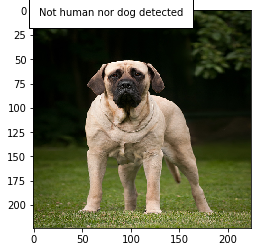

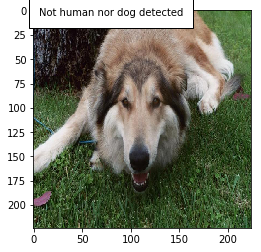

<class 'PIL.Image.Image'>


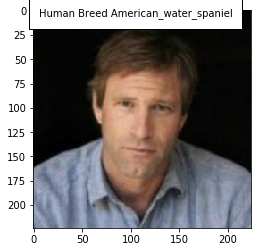

<class 'PIL.Image.Image'>


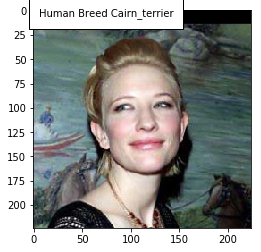

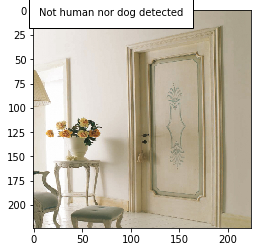

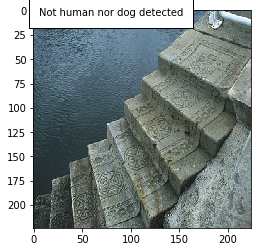

In [26]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
nothing = ["/media/rodsnjr/Files/Datasets/gvc_dataset_final/train/Doors/0ae64d1fb57d9f58a68cc356ac9d9f1a.jpg", 
           "/media/rodsnjr/Files/Datasets/gvc_dataset_final/testing/Stairs/01~0001.jpg"]

dogs = ["dogImages/train/103.Mastiff/Mastiff_06824.jpg",
       "dogImages/test/054.Collie/Collie_03790.jpg"]
humans = ["lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg", "lfw/Cate_Blanchett/Cate_Blanchett_0001.jpg"]

for dog in dogs:
    show_output(dog)

for human in humans:
    show_output(human)

for none in nothing:
    show_output(none)